## **Импорт**

In [64]:
!pip install pyheif
!pip install catboost
!pip install exifread
!pip install pillow_heif #heif->jpeg
!pip install piexif #heif->jpeg

In [65]:
# Общие библиотеки
import pandas as pd
from pandas import option_context
import numpy as np
import glob
from pathlib import Path
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import re  #
import sys #
import csv #

# Для проверки размерности тензоров и рабочего устройства
import torch

# Для работы с изображениями
import cv2
import PIL
from PIL import Image, ImageEnhance, ImageDraw, ImageFont, ExifTags
import PIL.Image as PILimage
from PIL.ExifTags import TAGS, GPSTAGS
import pyheif
from datetime import datetime
import io
import exifread
from pillow_heif import register_heif_opener # heif->jpeg
import piexif # heif->jpeg

# Для визуализации
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Для скачивания
#!pip install wget
#import wget

# Для случайностей
import random  

# Для метрики
from sklearn.metrics import r2_score

# Для сброса ОЗУ при необходимости
import gc

In [66]:
# Проверяем рабочее устройство
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("ATTENTION!!! no GPU found !!!")
print('Device: {}'.format(device))

ATTENTION!!! no GPU found !!!
Device: cpu


In [67]:
# Фиксируем поведение случайностей
seed = 1234
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

## **Подготовка путей**

In [6]:
# Подключаем диск с входными данными
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
# Упрощаем относительные пути к входным данным
CWD = f'/Users/roman_permyakov/python_projects/Ulianovsk/'
ROOT = Path(CWD)

# Скачиваем тренировочный датасет отсюда: https://lodmedia.hb.bizmrg.com/case_files/791333/train_dataset_train.zip
train_image_path = ROOT / "train_dataset_train" / 'train'

# Скачиваем тестовый датасет отсюда: https://lodmedia.hb.bizmrg.com/case_files/791333/test_dataset_test.zip
test_image_path = ROOT / "test"

ALL_IMAGES_JPEG = sorted(train_image_path.glob("*.jpg"))
ALL_IMAGES_HEIC = sorted(train_image_path.glob("*.heic"))

ALL_TEST_IMAGES_JPEG = sorted(test_image_path.glob("*.jpg"))
ALL_TEST_IMAGES_HEIC = sorted(test_image_path.glob("*.heic"))

# Считаем число тренировочных и тестовых снимков разных форматов
print("Тренировочных jpeg:", len(ALL_IMAGES_JPEG))
print("Тренировочных heic:",len(ALL_IMAGES_HEIC))
print("Тестовых jpeg:", len(ALL_TEST_IMAGES_JPEG))
print("Тестовых heic:",len(ALL_TEST_IMAGES_HEIC))

Тренировочных jpeg: 482
Тренировочных heic: 48
Тестовых jpeg: 485
Тестовых heic: 36


In [69]:
# Создаем списки с именами тренировочных и тестовых снимков
train_img_names = set(os.listdir(f'{CWD}train_dataset_train/train'))
test_img_names = set(os.listdir(f'{CWD}test'))
print("Тренировочных данных всего:", len(train_img_names))
print("Тестовых данных всего:", len(test_img_names))

Тренировочных данных всего: 530
Тестовых данных всего: 521


In [70]:
# Проверяем, что есть папка, в которой будем хранить промежуточные результаты
extra_folder = f'{CWD}extra_folder/'
if not os.path.exists(extra_folder):
    os.makedirs(extra_folder)

In [71]:
# Проверяем, что есть папки для хранения csv с данными exif
exif_data_dir = f'{extra_folder}exif_data/'
if not os.path.exists(exif_data_dir):
    os.makedirs(exif_data_dir)

exif_data_v1 = f'{exif_data_dir}v1/'
if not os.path.exists(exif_data_v1):
    os.makedirs(exif_data_v1)    

In [72]:
# Проверяем, что есть папки с данными об авто
car_dir = f'{extra_folder}car_data/'
if not os.path.exists(car_dir):
    os.makedirs(car_dir)

In [73]:
# Проверяем, что есть папки для хранения csv с объединенными данными exif и об авто
exif_car_dir = f'{extra_folder}exif_car_data/'
if not os.path.exists(exif_car_dir):
    os.makedirs(exif_car_dir)

In [74]:
# Проверяем, что есть папки с данными для хранения размеченных снимков
check_cars = f'{extra_folder}check_cars/'
if not os.path.exists(check_cars):
    os.makedirs(check_cars)

check_cars_v1 = f'{check_cars}v1/'
if not os.path.exists(check_cars_v1):
    os.makedirs(check_cars_v1)      

In [75]:
# Проверяем, что есть папка для хранения моделей
models = f'{extra_folder}models/'
if not os.path.exists(models):
    os.makedirs(models)

In [77]:
# Создаем датафрейм с именами и подписями тренировочных данных
train_labels_df = pd.read_csv(f'{CWD}train_dataset_train/train.csv', sep=';', index_col=None)
train_labels_df.head(2)
#train_labels_df.info()

,image_name,distance
0,img_1596.jpg,4.88
1,img_1600.jpg,1.54


## **Подготовка снимков. Извлечение exif из jpeg**

In [78]:
# Пишем функцию для извлечения exif из jpg и записи в csv

def jpg_exif_to_csv (img_path, out_dir, format, state, i): # i - уровень вложенности снимков
  
  def convert_to_degress(value):
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)
    return d + (m / 60.0) + (s / 3600.0)

  def convert_to_float(value):
    if '/' in value:
      num, denom = value.split('/')
      return float(num) / float(denom)
    else:
      pass


  def get_exif_data (ifile):
    if re.search (r'jpg$', str(ifile), re.IGNORECASE):
     image = Image.open(str(ifile))
     with open(ifile, 'rb') as f:
       tags = exifread.process_file(f, details=False)

       for tag in tags.keys():
         return (tags.get("Image Model"), 
                 tags.get('EXIF DateTimeOriginal'), 
                 str(tags.get('EXIF FocalLength')), 
                 tags.get('GPS GPSLatitude'),
                 tags.get('GPS GPSLongitude'),
                 str(tags.get('GPS GPSAltitude')),
                 str(tags.get('GPS GPSImgDirection')),
                 str(tags.get('EXIF ExposureTime')),
                 str(tags.get('EXIF FNumber')),
                 str(tags.get('EXIF ISOSpeedRatings')),
                 str(tags.get('EXIF DigitalZoomRatio')),
                 str(ifile).split("/")[i]) # проверить уровень вложенности снимков

  image_name_list = []
  date_list = []
  cam_list = []
  lat_list = []
  lon_list = []
  alt_list = []
  dir_list = []
  exp_list = []
  aper_list = []
  iso_list = []
  focus_list = []
  zoom_list = []

  def print_results (model, date, focus, lat, lon, alt, dir, exp, aper, iso, zoom, image_name):
    print( model, date, focus, lat, lon, alt, dir, exp, aper, zoom, image_name)

  for path in tqdm (Path(img_path).glob('*.jpg')):
    if path.is_file():
      model, date, focus, lat, lon, alt, dir, exp, aper, iso, zoom, image_name = get_exif_data(path)
      lat = convert_to_degress(lat)
      lon = convert_to_degress(lon)
      focus = convert_to_float(focus)
      aper = convert_to_float(aper)
      alt = convert_to_float (alt)
      dir = convert_to_float (dir)
      zoom = convert_to_float(zoom)
      #zoom = str(f'{zoom:.{5}f}')
      #dir = str(f'{dir:.{3}f}')
      #print_results(image_name, model, date, focus, lat, lon, alt, dir, exp, aper, iso, zoom)  

      image_name_list.append(image_name)
      date_list.append(date)
      cam_list.append(model)
      lat_list.append(lat)
      lon_list.append(lon)
      alt_list.append(alt)
      dir_list.append(dir)
      exp_list.append(exp)
      aper_list.append(aper)
      iso_list.append(iso)
      focus_list.append(focus)
      zoom_list.append(zoom)
    
      zipped = zip(image_name_list, date_list, cam_list, lat_list, lon_list, alt_list, dir_list,
                 exp_list, aper_list, iso_list, focus_list, zoom_list)
    
      with open(f'{out_dir}{state}_exif_{format}.csv', "w", newline='') as n:
        writer = csv.writer(n)
        writer.writerow(('image_name', 'date', 'camera_model', 'GPS_latitude', 'GPS_longitude', 'GPS_Altitude', 'GPS_Direction', 'exposure', 'aperture', 'iso', 'focus', 'zoom'))
        for row in zipped:
          writer.writerow(row)

In [79]:
# Экспорт exif из тренировочных jpg в csv
jpg_exif_to_csv (img_path = f'{train_image_path}',
                 out_dir = f'{exif_data_v1}',
                 format = 'jpg',
                 state = 'train',
                 i = 7)

482it [00:02, 167.48it/s]


In [80]:
# Экспорт exif из тестовых jpg в csv
jpg_exif_to_csv (img_path = f'{test_image_path}',
                 out_dir = f'{exif_data_v1}',
                 format = 'jpg',
                 state = 'test',
                 i = 6)

485it [00:02, 169.36it/s]


## **Подготовка снимков. Извлечение exif из heic**

In [81]:
# Пишем функцию для извлечения exif из heic и записи в csv

def heic_exif_to_csv (img_path, out_dir, format, state, i): # i - уровень вложенности снимков
  
  def convert_to_degress(value):
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)
    return d + (m / 60.0) + (s / 3600.0)

  def convert_to_float(value):
    num, denom = value.split('/')
    return float(num) / float(denom)

  def get_exif_data (ifile):
    if re.search (r'heic$', str(ifile), re.IGNORECASE):
      heif_file = pyheif.read_heif(str(ifile))
      for metadata in heif_file.metadata:
        
        if metadata in heif_file.metadata:
          if metadata['type']== 'Exif':
            fstream = io.BytesIO(metadata['data'][6:])

      tags = exifread.process_file(fstream, details=False)

      for tag in tags.keys():
        return (tags.get("Image Model"), 
                tags.get('EXIF DateTimeOriginal'), 
                str(tags.get('EXIF FocalLength')), 
                tags.get('GPS GPSLatitude'),
                tags.get('GPS GPSLongitude'),
                str(tags.get('GPS GPSAltitude')),
                str(tags.get('GPS GPSImgDirection')),
                str(tags.get('EXIF ExposureTime')),
                str(tags.get('EXIF FNumber')),
                str(tags.get('EXIF ISOSpeedRatings')),
                str(tags.get('EXIF DigitalZoomRatio')),
                str(ifile).split("/")[i]) # проверить уровень вложенности снимков

  image_name_list = []
  date_list = []
  cam_list = []
  lat_list = []
  lon_list = []
  alt_list = []
  dir_list = []
  exp_list = []
  aper_list = []
  iso_list = []
  focus_list = []
  zoom_list = []

  def print_results (model, date, focus, lat, lon, alt, dir, exp, aper, iso, zoom, image_name):
    print( model, date, focus, lat, lon, alt, dir, exp, aper, zoom, image_name)

  for path in tqdm (Path(img_path).glob('*.heic')):
    if path.is_file():
      model, date, focus, lat, lon, alt, dir, exp, aper, iso, zoom, image_name = get_exif_data(path)
      lat = convert_to_degress(lat)
      lon = convert_to_degress(lon)
      focus = convert_to_float(focus)
      aper = convert_to_float(aper)
      alt = convert_to_float (alt)
      dir = convert_to_float (dir)
      zoom = convert_to_float (zoom)
      zoom = str(f"{zoom:.{5}f}")
      #dir = str(f"{dir:.{3}f}")
      #print_results(image_name, model, date, focus, lat, lon, alt, dir, exp, aper, iso, zoom)  

      image_name_list.append(image_name)
      date_list.append(date)
      cam_list.append(model)
      lat_list.append(lat)
      lon_list.append(lon)
      alt_list.append(alt)
      dir_list.append(dir)
      exp_list.append(exp)
      aper_list.append(aper)
      iso_list.append(iso)
      focus_list.append(focus)
      zoom_list.append(zoom)
    
      zipped = zip(image_name_list, date_list, cam_list, lat_list, lon_list, alt_list, dir_list,
                 exp_list, aper_list, iso_list, focus_list, zoom_list)
    
      with open(f'{out_dir}{state}_exif_{format}.csv', "w", newline='') as n:
        writer = csv.writer(n)
        writer.writerow(('image_name', 'date', 'camera_model', 'GPS_latitude', 'GPS_longitude', 'GPS_Altitude', 'GPS_Direction', 'exposure', 'aperture', 'iso', 'focus', 'zoom'))
        for row in zipped:
          writer.writerow(row)

In [82]:
# Экспорт exif из тренировочных heic в csv
heic_exif_to_csv (img_path = f'{train_image_path}',
                  out_dir = f'{exif_data_v1}',
                  format = 'heic',
                  state = 'train',
                  i = 7)

48it [00:18,  2.62it/s]


In [83]:
# Экспорт exif из тестовых heic в csv
heic_exif_to_csv (img_path = f'{test_image_path}',
                  out_dir = f'{exif_data_v1}',
                  format = 'heic',
                  state = 'test',
                  i = 6)

36it [00:14,  2.55it/s]


## **Подготовка обогащения данными из exif**

Создаем тренировочные и тестовые датафреймы с параметрами автомобилей из подготовленных вручную файлов **.csv**.

Файлы **.csv** получены после визуального дешифрирования брендов, моделей, поколения, типов кузова и цветов автомобилей с использованием информации об их ширине и высоте с сайта: https://auto.ru.



---


Описание атрибутов из exif:
* **Date**: дата в формате: *год-месяц-число*
* **Time**: время в формате: *часы-минуты-секунды*
* **Camera model**: модель камеры (IPhone 11 или IPhone 12)
* **Exposure (1/sec)**: экспозиция съемки
* **Aperture**: апертура объектива
* **ISO**: чувствительность датчика камеры
* **GPS latitude**: широта места в градусах
* **GPS longitude**: долгота места в градусах
* **GPS altitude**: высота места в метрах
* **GPS direction**: азимут съемки в градусах.

Описание доп.атрибутов:
* **Car_model**: марка и модель автомобиля (+ опционально кузов и версия)
* **Car_colour**: цвет автомобиля.

#### **Для тренировочных данных**



In [84]:
# JPEG c exif
train_exif_jpg_df = pd.read_csv(f'{exif_data_v1}/train_exif_jpg.csv', sep=',', index_col=None)
train_exif_jpg_df.info()
train_exif_jpg_df.sort_values(by = "zoom").tail(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     482 non-null    object 
 1   date           482 non-null    object 
 2   camera_model   482 non-null    object 
 3   GPS_latitude   482 non-null    float64
 4   GPS_longitude  482 non-null    float64
 5   GPS_Altitude   482 non-null    float64
 6   GPS_Direction  482 non-null    float64
 7   exposure       482 non-null    object 
 8   aperture       482 non-null    float64
 9   iso            482 non-null    int64  
 10  focus          482 non-null    float64
 11  zoom           476 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 45.3+ KB


,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
47,img_1650.jpg,2022:07:07 11:51:51,iPhone 11,54.330203,48.393981,182.774834,340.374771,1/558,2.4,20,1.54,1.379562
104,img_1619.jpg,2022:07:07 11:13:00,iPhone 11,54.329544,48.395333,181.700450,341.384522,1/1838,1.8,32,4.25,NaN
120,img_1618.jpg,2022:07:07 11:12:48,iPhone 11,54.329544,48.395358,181.542827,334.214065,1/1808,1.8,32,4.25,NaN
190,img_1620.jpg,2022:07:07 11:13:16,iPhone 11,54.329533,48.395339,181.809618,340.160858,1/1838,1.8,32,4.25,NaN
206,img_1621.jpg,2022:07:07 11:13:32,iPhone 11,54.329544,48.395333,181.166610,337.938889,1/1808,1.8,32,4.25,NaN
285,img_1616.jpg,2022:07:07 11:12:17,iPhone 11,54.329553,48.395344,180.999236,334.323090,1/1866,1.8,32,4.25,NaN
316,img_1615.jpg,2022:07:07 11:12:05,iPhone 11,54.329569,48.395503,180.881248,338.982147,1/1898,1.8,32,4.25,NaN


In [85]:
# Ячейки без зума заполняем самым распространенным значением (1.23529)
train_exif_jpg_df.fillna(value = 1.23529, inplace=True) 
train_exif_jpg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     482 non-null    object 
 1   date           482 non-null    object 
 2   camera_model   482 non-null    object 
 3   GPS_latitude   482 non-null    float64
 4   GPS_longitude  482 non-null    float64
 5   GPS_Altitude   482 non-null    float64
 6   GPS_Direction  482 non-null    float64
 7   exposure       482 non-null    object 
 8   aperture       482 non-null    float64
 9   iso            482 non-null    int64  
 10  focus          482 non-null    float64
 11  zoom           482 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 45.3+ KB


In [86]:
#  Заменяем фокусное расстояние 4.25 на самое распространенное 1.54
train_exif_jpg_df.replace(4.25, 1.54, inplace = True)
train_exif_jpg_df.sort_values(by='focus')

,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
0,img_1861.jpg,2022:07:12 15:45:37,iPhone 11,54.301964,48.376408,125.485990,170.104683,1/122,2.4,20,1.54,1.022312
328,img_2725.jpg,2022:07:13 10:13:33,iPhone 11,54.304928,48.375992,128.270294,352.890808,1/484,2.4,20,1.54,1.059566
327,img_2730.jpg,2022:07:13 10:14:07,iPhone 11,54.305011,48.376000,129.653764,342.141770,1/457,2.4,20,1.54,1.059566
326,img_2903.jpg,2022:07:13 12:03:19,iPhone 11,54.330217,48.394281,182.214218,93.413496,1/403,2.4,20,1.54,1.022312
325,img_1991.jpg,2022:07:12 16:20:50,iPhone 11,54.301925,48.374608,120.840023,120.996561,1/122,2.4,25,1.54,1.022312
...,...,...,...,...,...,...,...,...,...,...,...,...
154,img_2470.jpg,2022:07:13 09:06:39,iPhone 11,54.301108,48.375044,125.521718,258.095245,1/406,2.4,20,1.54,1.022312
153,img_2458.jpg,2022:07:13 09:04:49,iPhone 11,54.301133,48.375428,122.962376,86.486053,1/122,2.4,25,1.54,1.022312
152,img_1637.jpg,2022:07:07 11:47:56,iPhone 11,54.330219,48.393864,182.755757,284.867584,1/122,2.4,64,1.54,1.379562
120,img_1618.jpg,2022:07:07 11:12:48,iPhone 11,54.329544,48.395358,181.542827,334.214065,1/1808,1.8,32,1.54,1.235290


In [87]:
# Выделяем значимую часть в экспозиции
train_exif_jpg_df['exposure'] = train_exif_jpg_df['exposure'].apply(lambda x: int(x.split(' ')[0].split('/')[1]))

In [88]:
train_exif_jpg_df.info()
train_exif_jpg_df.sort_values(by = 'exposure')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     482 non-null    object 
 1   date           482 non-null    object 
 2   camera_model   482 non-null    object 
 3   GPS_latitude   482 non-null    float64
 4   GPS_longitude  482 non-null    float64
 5   GPS_Altitude   482 non-null    float64
 6   GPS_Direction  482 non-null    float64
 7   exposure       482 non-null    int64  
 8   aperture       482 non-null    float64
 9   iso            482 non-null    int64  
 10  focus          482 non-null    float64
 11  zoom           482 non-null    float64
dtypes: float64(7), int64(2), object(3)
memory usage: 45.3+ KB


,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
384,img_1841.jpg,2022:07:12 15:38:50,iPhone 11,54.302911,48.378075,129.458726,331.476822,111,2.4,200,1.54,1.022312
116,img_2271.jpg,2022:07:12 17:40:40,iPhone 11,54.297061,48.370439,122.715403,117.043999,121,2.4,125,1.54,1.022312
467,img_2550.jpg,2022:07:13 09:27:25,iPhone 11,54.302472,48.375558,131.981461,20.123657,121,2.4,64,1.54,1.022312
208,img_2664.jpg,2022:07:13 09:50:11,iPhone 11,54.303483,48.378100,144.644784,267.877578,121,2.4,64,1.54,1.022312
313,img_2650.jpg,2022:07:13 09:48:23,iPhone 11,54.303367,48.378178,145.228812,273.365723,121,2.4,64,1.54,1.022312
...,...,...,...,...,...,...,...,...,...,...,...,...
104,img_1619.jpg,2022:07:07 11:13:00,iPhone 11,54.329544,48.395333,181.700450,341.384522,1838,1.8,32,1.54,1.235290
190,img_1620.jpg,2022:07:07 11:13:16,iPhone 11,54.329533,48.395339,181.809618,340.160858,1838,1.8,32,1.54,1.235290
285,img_1616.jpg,2022:07:07 11:12:17,iPhone 11,54.329553,48.395344,180.999236,334.323090,1866,1.8,32,1.54,1.235290
316,img_1615.jpg,2022:07:07 11:12:05,iPhone 11,54.329569,48.395503,180.881248,338.982147,1898,1.8,32,1.54,1.235290


In [89]:
# HEIC c exif
train_exif_heic_df = pd.read_csv(f'{exif_data_v1}train_exif_heic.csv', sep=',', index_col=None)
train_exif_heic_df.info()
train_exif_heic_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     48 non-null     object 
 1   date           48 non-null     object 
 2   camera_model   48 non-null     object 
 3   GPS_latitude   48 non-null     float64
 4   GPS_longitude  48 non-null     float64
 5   GPS_Altitude   48 non-null     float64
 6   GPS_Direction  48 non-null     float64
 7   exposure       48 non-null     object 
 8   aperture       48 non-null     float64
 9   iso            48 non-null     int64  
 10  focus          48 non-null     float64
 11  zoom           48 non-null     float64
dtypes: float64(7), int64(1), object(4)
memory usage: 4.6+ KB


,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
0,img_2754.heic,2022:07:10 21:31:39,iPhone 12,54.307094,48.361922,101.192116,71.027252,1/25,2.4,1600,1.55,1.03279
1,img_2685.heic,2022:07:10 21:14:51,iPhone 12,54.307083,48.361908,101.192116,318.886124,1/25,2.4,1250,1.55,1.03279


In [90]:
# Выделяем значимую часть в экспозиции
train_exif_heic_df['exposure'] = train_exif_heic_df['exposure'].apply(lambda x: int(x.split(' ')[0].split('/')[1]))
#train_exif_heic_df.info()
train_exif_heic_df.head(2)

,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
0,img_2754.heic,2022:07:10 21:31:39,iPhone 12,54.307094,48.361922,101.192116,71.027252,25,2.4,1600,1.55,1.03279
1,img_2685.heic,2022:07:10 21:14:51,iPhone 12,54.307083,48.361908,101.192116,318.886124,25,2.4,1250,1.55,1.03279


In [91]:
# Объединенный тренировочный датафрейм с exif
train_exif_df = pd.concat([train_exif_jpg_df, train_exif_heic_df], ignore_index=True)
train_exif_df.info()
train_exif_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     530 non-null    object 
 1   date           530 non-null    object 
 2   camera_model   530 non-null    object 
 3   GPS_latitude   530 non-null    float64
 4   GPS_longitude  530 non-null    float64
 5   GPS_Altitude   530 non-null    float64
 6   GPS_Direction  530 non-null    float64
 7   exposure       530 non-null    int64  
 8   aperture       530 non-null    float64
 9   iso            530 non-null    int64  
 10  focus          530 non-null    float64
 11  zoom           530 non-null    float64
dtypes: float64(7), int64(2), object(3)
memory usage: 49.8+ KB


,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
0,img_1861.jpg,2022:07:12 15:45:37,iPhone 11,54.301964,48.376408,125.485990,170.104683,122,2.4,20,1.54,1.022312
1,img_1691.jpg,2022:07:07 17:14:11,iPhone 11,54.329558,48.392636,182.106317,185.318962,122,2.4,20,1.54,1.237316


In [92]:
# Создаем новые атрибуты: выделяем значащие части у старых и при необходимости меняем их формат
train_exif_df_copy = train_exif_df.copy(deep=True)
train_exif_df_copy['iphone'] = train_exif_df_copy['camera_model'].str[-2:]
train_exif_df_copy['day'] = train_exif_df_copy['date'].str[8:10].astype(int)
train_exif_df_copy['hour'] = train_exif_df_copy['date'].str[11:13].astype(int)
train_exif_df_copy['minute'] = train_exif_df_copy['date'].str[14:16].astype(int)
train_exif_df_copy['second'] = train_exif_df_copy['date'].str[17:19].astype(int)
#train_exif_df_copy.info()
train_exif_df_copy.head()

,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom,iphone,day,hour,minute,second
0,img_1861.jpg,2022:07:12 15:45:37,iPhone 11,54.301964,48.376408,125.485990,170.104683,122,2.4,20,1.54,1.022312,11,12,15,45,37
1,img_1691.jpg,2022:07:07 17:14:11,iPhone 11,54.329558,48.392636,182.106317,185.318962,122,2.4,20,1.54,1.237316,11,7,17,14,11
2,img_2398.jpg,2022:07:13 08:49:49,iPhone 11,54.302772,48.376281,127.799834,105.006947,122,2.4,50,1.54,1.022312,11,13,8,49,49
3,img_1685.jpg,2022:07:07 17:13:00,iPhone 11,54.329575,48.392547,181.534224,183.689796,137,2.4,20,1.54,1.237316,11,7,17,13,0
4,img_2373.jpg,2022:07:13 08:46:26,iPhone 11,54.302842,48.376194,135.871228,127.518131,126,2.4,20,1.54,1.022312,11,13,8,46,26


In [93]:
# Удаляем лишние атрибуты
train_exif_df_copy2= train_exif_df_copy.copy(deep=True)
train_exif_df_copy2 = train_exif_df_copy2.drop(['date', 'camera_model'], axis=1)
train_exif_df_copy2.info()
train_exif_df_copy2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     530 non-null    object 
 1   GPS_latitude   530 non-null    float64
 2   GPS_longitude  530 non-null    float64
 3   GPS_Altitude   530 non-null    float64
 4   GPS_Direction  530 non-null    float64
 5   exposure       530 non-null    int64  
 6   aperture       530 non-null    float64
 7   iso            530 non-null    int64  
 8   focus          530 non-null    float64
 9   zoom           530 non-null    float64
 10  iphone         530 non-null    object 
 11  day            530 non-null    int64  
 12  hour           530 non-null    int64  
 13  minute         530 non-null    int64  
 14  second         530 non-null    int64  
dtypes: float64(7), int64(6), object(2)
memory usage: 62.2+ KB


,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom,iphone,day,hour,minute,second
0,img_1861.jpg,54.301964,48.376408,125.485990,170.104683,122,2.4,20,1.54,1.022312,11,12,15,45,37
1,img_1691.jpg,54.329558,48.392636,182.106317,185.318962,122,2.4,20,1.54,1.237316,11,7,17,14,11


#### **Для тестовых данных**

In [94]:
# JPEG c exif
test_exif_jpg_df = pd.read_csv(f'{exif_data_v1}test_exif_jpg.csv', sep=',', index_col=None)
test_exif_jpg_df.info()
test_exif_jpg_df.sort_values(by = "zoom").tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     485 non-null    object 
 1   date           485 non-null    object 
 2   camera_model   485 non-null    object 
 3   GPS_latitude   485 non-null    float64
 4   GPS_longitude  485 non-null    float64
 5   GPS_Altitude   485 non-null    float64
 6   GPS_Direction  485 non-null    float64
 7   exposure       485 non-null    object 
 8   aperture       485 non-null    float64
 9   iso            485 non-null    int64  
 10  focus          485 non-null    float64
 11  zoom           484 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 45.6+ KB


,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
8,img_1646.jpg,2022:07:07 11:51:08,iPhone 11,54.330228,48.393925,182.621561,332.167664,1/421,2.4,20,1.54,1.379562
397,img_1664.jpg,2022:07:07 11:56:26,iPhone 11,54.330208,48.394169,182.272765,88.150360,1/872,2.4,20,1.54,1.379562
323,img_1617.jpg,2022:07:07 11:12:34,iPhone 11,54.329536,48.395356,181.582868,336.718506,1/1838,1.8,32,4.25,NaN


In [95]:
# Ячейки без зума заполняем самым распространенным значением (1.23529)
test_exif_jpg_df.fillna(value = 1.23529, inplace=True) 
test_exif_jpg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     485 non-null    object 
 1   date           485 non-null    object 
 2   camera_model   485 non-null    object 
 3   GPS_latitude   485 non-null    float64
 4   GPS_longitude  485 non-null    float64
 5   GPS_Altitude   485 non-null    float64
 6   GPS_Direction  485 non-null    float64
 7   exposure       485 non-null    object 
 8   aperture       485 non-null    float64
 9   iso            485 non-null    int64  
 10  focus          485 non-null    float64
 11  zoom           485 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 45.6+ KB


In [96]:
#  Заменяем фокусное расстояние 4.25 на самое распространенное 1.54
test_exif_jpg_df.replace(4.25, 1.54, inplace = True)
test_exif_jpg_df.sort_values(by='focus')

,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
0,img_2603.jpg,2022:07:13 09:38:27,iPhone 11,54.302558,48.375842,132.860088,89.476440,1/122,2.4,40,1.54,1.022312
330,img_2877.jpg,2022:07:13 11:59:43,iPhone 11,54.330203,48.394853,182.378876,173.431236,1/578,2.4,20,1.54,1.022312
329,img_2875.jpg,2022:07:13 11:59:18,iPhone 11,54.330181,48.394869,182.077294,71.175354,1/639,2.4,20,1.54,1.022312
328,img_2685.jpg,2022:07:13 09:53:41,iPhone 11,54.303619,48.378292,154.747178,7.044037,1/173,2.4,20,1.54,1.022312
327,img_2652.jpg,2022:07:13 09:48:36,iPhone 11,54.303433,48.378150,143.354594,270.482300,1/122,2.4,40,1.54,1.022312
...,...,...,...,...,...,...,...,...,...,...,...,...
154,img_2307.jpg,2022:07:12 17:49:57,iPhone 11,54.296228,48.371308,125.730648,321.692795,1/122,2.4,32,1.54,1.022312
153,img_2461.jpg,2022:07:13 09:05:13,iPhone 11,54.301150,48.375431,122.118848,93.338561,1/122,2.4,40,1.54,1.022312
152,img_2475.jpg,2022:07:13 09:07:28,iPhone 11,54.301119,48.375000,127.699621,253.288086,1/424,2.4,20,1.54,1.022312
180,img_2676.jpg,2022:07:13 09:52:11,iPhone 11,54.303344,48.378094,150.878297,259.856888,1/121,2.4,64,1.54,1.022312


In [97]:
# Выделяем значимую часть в экспозиции
test_exif_jpg_df['exposure'] = test_exif_jpg_df['exposure'].apply(lambda x: int(x.split(' ')[0].split('/')[1]))

In [98]:
test_exif_jpg_df.info()
test_exif_jpg_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     485 non-null    object 
 1   date           485 non-null    object 
 2   camera_model   485 non-null    object 
 3   GPS_latitude   485 non-null    float64
 4   GPS_longitude  485 non-null    float64
 5   GPS_Altitude   485 non-null    float64
 6   GPS_Direction  485 non-null    float64
 7   exposure       485 non-null    int64  
 8   aperture       485 non-null    float64
 9   iso            485 non-null    int64  
 10  focus          485 non-null    float64
 11  zoom           485 non-null    float64
dtypes: float64(7), int64(2), object(3)
memory usage: 45.6+ KB


,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
0,img_2603.jpg,2022:07:13 09:38:27,iPhone 11,54.302558,48.375842,132.860088,89.476440,122,2.4,40,1.54,1.022312
1,img_2617.jpg,2022:07:13 09:40:17,iPhone 11,54.302533,48.375850,134.158700,266.696899,122,2.4,25,1.54,1.022312


In [99]:
# HEIC c exif
test_exif_heic_df = pd.read_csv(f'{exif_data_v1}test_exif_heic.csv', sep=',', index_col=None)
test_exif_heic_df.info()
test_exif_heic_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     36 non-null     object 
 1   date           36 non-null     object 
 2   camera_model   36 non-null     object 
 3   GPS_latitude   36 non-null     float64
 4   GPS_longitude  36 non-null     float64
 5   GPS_Altitude   36 non-null     float64
 6   GPS_Direction  36 non-null     float64
 7   exposure       36 non-null     object 
 8   aperture       36 non-null     float64
 9   iso            36 non-null     int64  
 10  focus          36 non-null     float64
 11  zoom           36 non-null     float64
dtypes: float64(7), int64(1), object(4)
memory usage: 3.5+ KB


,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
0,img_2703.heic,2022:07:10 21:18:06,iPhone 12,54.306950,48.361839,101.192116,317.397507,1/25,2.4,1250,1.55,1.03279
1,img_2742.heic,2022:07:10 21:26:54,iPhone 12,54.307081,48.361903,101.192116,108.100239,1/25,2.4,2000,1.55,1.03279


In [100]:
# Объединенный тестовый датафрейм c exif
test_exif_df = pd.concat([test_exif_jpg_df, test_exif_heic_df], ignore_index=True)
test_exif_df.info()
test_exif_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     521 non-null    object 
 1   date           521 non-null    object 
 2   camera_model   521 non-null    object 
 3   GPS_latitude   521 non-null    float64
 4   GPS_longitude  521 non-null    float64
 5   GPS_Altitude   521 non-null    float64
 6   GPS_Direction  521 non-null    float64
 7   exposure       521 non-null    object 
 8   aperture       521 non-null    float64
 9   iso            521 non-null    int64  
 10  focus          521 non-null    float64
 11  zoom           521 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 49.0+ KB


,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom
0,img_2603.jpg,2022:07:13 09:38:27,iPhone 11,54.302558,48.375842,132.860088,89.476440,122,2.4,40,1.54,1.022312
1,img_2617.jpg,2022:07:13 09:40:17,iPhone 11,54.302533,48.375850,134.158700,266.696899,122,2.4,25,1.54,1.022312


In [101]:
# Создаем новые атрибуты: выделяем значащие части у старых и при необходимости меняем их формат
test_exif_df_copy = test_exif_df.copy(deep=True)
test_exif_df_copy['iphone'] = test_exif_df_copy['camera_model'].str[-2:]
test_exif_df_copy['day'] = test_exif_df_copy['date'].str[8:10].astype(int)
test_exif_df_copy['hour'] = test_exif_df_copy['date'].str[11:13].astype(int)
test_exif_df_copy['minute'] = test_exif_df_copy['date'].str[14:16].astype(int)
test_exif_df_copy['second'] = test_exif_df_copy['date'].str[17:19].astype(int)
#test_exif_df_copy.info()
test_exif_df_copy.head()

,image_name,date,camera_model,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom,iphone,day,hour,minute,second
0,img_2603.jpg,2022:07:13 09:38:27,iPhone 11,54.302558,48.375842,132.860088,89.476440,122,2.4,40,1.54,1.022312,11,13,9,38,27
1,img_2617.jpg,2022:07:13 09:40:17,iPhone 11,54.302533,48.375850,134.158700,266.696899,122,2.4,25,1.54,1.022312,11,13,9,40,17
2,img_1875.jpg,2022:07:12 15:48:58,iPhone 11,54.301722,48.375969,124.148892,271.118271,207,2.4,20,1.54,1.022312,11,12,15,48,58
3,img_1849.jpg,2022:07:12 15:41:19,iPhone 11,54.302383,48.378169,128.334349,72.235687,131,2.4,20,1.54,1.022312,11,12,15,41,19
4,img_2401.jpg,2022:07:13 08:50:14,iPhone 11,54.302764,48.376214,130.665304,98.855926,121,2.4,64,1.54,1.022312,11,13,8,50,14


In [102]:
# Удаляем лишние атрибуты
test_exif_df_copy2= test_exif_df_copy.copy(deep=True)
test_exif_df_copy2 = test_exif_df_copy2.drop(['date', 'camera_model'], axis=1)
test_exif_df_copy2.info()
test_exif_df_copy2.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     521 non-null    object 
 1   GPS_latitude   521 non-null    float64
 2   GPS_longitude  521 non-null    float64
 3   GPS_Altitude   521 non-null    float64
 4   GPS_Direction  521 non-null    float64
 5   exposure       521 non-null    object 
 6   aperture       521 non-null    float64
 7   iso            521 non-null    int64  
 8   focus          521 non-null    float64
 9   zoom           521 non-null    float64
 10  iphone         521 non-null    object 
 11  day            521 non-null    int64  
 12  hour           521 non-null    int64  
 13  minute         521 non-null    int64  
 14  second         521 non-null    int64  
dtypes: float64(7), int64(5), object(3)
memory usage: 61.2+ KB


,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom,iphone,day,hour,minute,second
0,img_2603.jpg,54.302558,48.375842,132.860088,89.476440,122,2.4,40,1.54,1.022312,11,13,9,38,27
1,img_2617.jpg,54.302533,48.375850,134.158700,266.696899,122,2.4,25,1.54,1.022312,11,13,9,40,17


## **Подготовка обогащения данными об автомобилях**

### **Для тренировочных данных**

In [103]:
# JPEG c авто
train_car_jpg_df = pd.read_csv(f'{car_dir}train_car_jpg.csv', sep=',', index_col=None)
train_car_jpg_df.info()
train_car_jpg_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_name    482 non-null    object 
 1   car_brand     482 non-null    object 
 2   car_model     482 non-null    object 
 3   car_gen       482 non-null    object 
 4   car_body      482 non-null    object 
 5   car_colour    482 non-null    object 
 6   car_width_m   482 non-null    float64
 7   car_height_m  482 non-null    float64
dtypes: float64(2), object(6)
memory usage: 30.2+ KB


,image_name,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_1596.jpg,Datsun,Ondo,New,Hatch,Red,1.70,1.50
1,img_1600.jpg,Datsun,Ondo,New,Hatch,Red,1.70,1.50
2,img_1601.jpg,Lada,Niva,Old,SUV,Violet,1.68,1.64
3,img_1603.jpg,Lada,Niva,Old,SUV,Violet,1.68,1.64
4,img_1605.jpg,Lada,Niva,Old,SUV,Violet,1.68,1.64


In [104]:
# HEIC c авто
train_car_heic_df = pd.read_csv(f'{car_dir}train_car_heic.csv', sep=',', index_col=None)
train_car_heic_df.info()
train_car_heic_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_name    48 non-null     object 
 1   car_brand     48 non-null     object 
 2   car_model     48 non-null     object 
 3   car_gen       48 non-null     object 
 4   car_body      48 non-null     object 
 5   car_colour    48 non-null     object 
 6   car_width_m   48 non-null     float64
 7   car_height_m  48 non-null     float64
dtypes: float64(2), object(6)
memory usage: 3.1+ KB


,image_name,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_2672.heic,Lada,Series_2112,Old,Hatch,Dark-Grey,1.68,1.42
1,img_2673.heic,Lada,Series_2112,Old,Hatch,Dark-Grey,1.68,1.42
2,img_2675.heic,Lada,Series_2112,Old,Hatch,Dark-Grey,1.68,1.42
3,img_2676.heic,Lada,Series_2112,Old,Hatch,Dark-Grey,1.68,1.42
4,img_2678.heic,Lada,Series_2112,Old,Hatch,Dark-Grey,1.68,1.42


In [105]:
# Объединенный тренировочный датафрейм с авто
train_car_df = pd.concat([train_car_jpg_df, train_car_heic_df], ignore_index=True)
#train_car_df.info()
train_car_df.head(2)

,image_name,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_1596.jpg,Datsun,Ondo,New,Hatch,Red,1.7,1.5
1,img_1600.jpg,Datsun,Ondo,New,Hatch,Red,1.7,1.5


### **Для тестовых данных**

In [106]:
# JPEG c авто
test_car_jpg_df = pd.read_csv(f'{car_dir}test_car_jpg.csv', sep=',', index_col=None)
test_car_jpg_df.info()
test_car_jpg_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_name    485 non-null    object 
 1   car_brand     485 non-null    object 
 2   car_model     485 non-null    object 
 3   car_gen       485 non-null    object 
 4   car_body      485 non-null    object 
 5   car_colour    485 non-null    object 
 6   car_width_m   485 non-null    float64
 7   car_height_m  485 non-null    float64
dtypes: float64(2), object(6)
memory usage: 30.4+ KB


,image_name,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_1597.jpg,Datsun,Ondo,New,Hatch,Red,1.70,1.50
1,img_1598.jpg,Datsun,Ondo,New,Hatch,Red,1.70,1.50
2,img_1599.jpg,Datsun,Ondo,New,Hatch,Red,1.70,1.50
3,img_1602.jpg,Lada,Niva,Old,SUV,Violet,1.68,1.64
4,img_1604.jpg,Lada,Niva,Old,SUV,Violet,1.68,1.64


In [107]:
# HEIC c авто
test_car_heic_df = pd.read_csv(f'{car_dir}test_car_heic.csv', sep=',', index_col=None)
test_car_heic_df.info()
test_car_heic_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_name    36 non-null     object 
 1   car_brand     36 non-null     object 
 2   car_model     36 non-null     object 
 3   car_gen       36 non-null     object 
 4   car_body      36 non-null     object 
 5   car_colour    36 non-null     object 
 6   car_width_m   36 non-null     float64
 7   car_height_m  36 non-null     float64
dtypes: float64(2), object(6)
memory usage: 2.4+ KB


,image_name,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_2674.heic,Lada,Series_2112,Old,Hatch,Dark-Grey,1.68,1.42
1,img_2677.heic,Lada,Series_2112,Old,Hatch,Dark-Grey,1.68,1.42
2,img_2679.heic,Lada,Series_2112,Old,Hatch,Dark-Grey,1.68,1.42
3,img_2684.heic,Nissan,Almera,Old,Sedan,Black,1.71,1.44
4,img_2686.heic,Nissan,Almera,Old,Sedan,Black,1.71,1.44


In [108]:
# Объединенный тестовый датафрейм с авто
test_car_df = pd.concat([test_car_jpg_df, test_car_heic_df], ignore_index=True)
test_car_df.info()
test_car_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_name    521 non-null    object 
 1   car_brand     521 non-null    object 
 2   car_model     521 non-null    object 
 3   car_gen       521 non-null    object 
 4   car_body      521 non-null    object 
 5   car_colour    521 non-null    object 
 6   car_width_m   521 non-null    float64
 7   car_height_m  521 non-null    float64
dtypes: float64(2), object(6)
memory usage: 32.7+ KB


,image_name,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_1597.jpg,Datsun,Ondo,New,Hatch,Red,1.7,1.5
1,img_1598.jpg,Datsun,Ondo,New,Hatch,Red,1.7,1.5


## **Объединение данных из exif и о машинах**

### **Для тренировочных данных**

In [109]:
train_car_exif_df = pd.merge(train_exif_df_copy2, train_car_df, how='left')
#train_car_exif_df.info()
train_car_exif_df.head(2)

,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom,...,hour,minute,second,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_1861.jpg,54.301964,48.376408,125.485990,170.104683,122,2.4,20,1.54,1.022312,...,15,45,37,Mitsubishi,Carisma,Old,Sedan,Grey,1.710,1.41
1,img_1691.jpg,54.329558,48.392636,182.106317,185.318962,122,2.4,20,1.54,1.237316,...,17,14,11,Toyota,RAV4,New,SUV,White,1.845,1.67


In [110]:
# Сохраняем объединенный тренировочный датафрейм в виде .csv
filepath = Path(f'{exif_car_dir}train_car_exif_df.csv') 
train_car_exif_df.to_csv(filepath, index = False)

In [111]:
# Загружаем размеченный и сохраненный csv (опционально)
train_car_exif_df = pd.read_csv(f'{exif_car_dir}train_car_exif_df.csv', sep=',', index_col=None)
train_car_exif_df.head(2)
train_car_exif_df.info()
train_car_exif_df.sort_values (by='image_name').head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     530 non-null    object 
 1   GPS_latitude   530 non-null    float64
 2   GPS_longitude  530 non-null    float64
 3   GPS_Altitude   530 non-null    float64
 4   GPS_Direction  530 non-null    float64
 5   exposure       530 non-null    int64  
 6   aperture       530 non-null    float64
 7   iso            530 non-null    int64  
 8   focus          530 non-null    float64
 9   zoom           530 non-null    float64
 10  iphone         530 non-null    int64  
 11  day            530 non-null    int64  
 12  hour           530 non-null    int64  
 13  minute         530 non-null    int64  
 14  second         530 non-null    int64  
 15  car_brand      530 non-null    object 
 16  car_model      530 non-null    object 
 17  car_gen        530 non-null    object 
 18  car_body  

,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom,...,hour,minute,second,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
164,img_1596.jpg,54.329636,48.395469,181.602886,171.064606,675,2.4,20,1.54,1.234286,...,11,2,48,Datsun,Ondo,New,Hatch,Red,1.7,1.5
342,img_1600.jpg,54.329442,48.395364,181.625730,173.650040,309,2.4,20,1.54,1.261051,...,11,5,18,Datsun,Ondo,New,Hatch,Red,1.7,1.5


### **Для тестовых данных**

In [112]:
test_car_exif_df = pd.merge(test_exif_df_copy2, test_car_df, how='left')
#test_car_exif_df.info()
test_car_exif_df.head(2)

,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom,...,hour,minute,second,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_2603.jpg,54.302558,48.375842,132.860088,89.476440,122,2.4,40,1.54,1.022312,...,9,38,27,Kia,Rio,Old,Hatch,Grey,1.695,1.47
1,img_2617.jpg,54.302533,48.375850,134.158700,266.696899,122,2.4,25,1.54,1.022312,...,9,40,17,Toyota,Carib,Old,Universal,Blue,1.695,1.46


In [114]:
# Сохраняем объединенный тестовый датафрейм в виде .csv
filepath = Path(f'{exif_car_dir}test_car_exif_df.csv') 
test_car_exif_df.to_csv(filepath, index = False)

In [115]:
# Загружаем объединенный тестовый датафрейм в виде .csv 
test_car_exif_df = pd.read_csv(f'{exif_car_dir}test_car_exif_df.csv', sep=',', index_col=None)
test_car_exif_df.head(2)
test_car_exif_df.info()
test_car_exif_df.sort_values (by='image_name').head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     521 non-null    object 
 1   GPS_latitude   521 non-null    float64
 2   GPS_longitude  521 non-null    float64
 3   GPS_Altitude   521 non-null    float64
 4   GPS_Direction  521 non-null    float64
 5   exposure       521 non-null    object 
 6   aperture       521 non-null    float64
 7   iso            521 non-null    int64  
 8   focus          521 non-null    float64
 9   zoom           521 non-null    float64
 10  iphone         521 non-null    int64  
 11  day            521 non-null    int64  
 12  hour           521 non-null    int64  
 13  minute         521 non-null    int64  
 14  second         521 non-null    int64  
 15  car_brand      521 non-null    object 
 16  car_model      521 non-null    object 
 17  car_gen        521 non-null    object 
 18  car_body  

,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,exposure,aperture,iso,focus,zoom,...,hour,minute,second,car_brand,car_model,car_gen,car_body,car_colour,car_width_m,car_height_m
189,img_1597.jpg,54.329494,48.395375,181.359981,175.779343,615,2.4,20,1.54,1.261051,...,11,3,43,Datsun,Ondo,New,Hatch,Red,1.7,1.5
247,img_1598.jpg,54.329442,48.395292,181.480336,176.149368,466,2.4,20,1.54,1.261051,...,11,4,10,Datsun,Ondo,New,Hatch,Red,1.7,1.5


## **Разметка и обогащение тренировочных данных**

### **Импорт моделей YOLO**
При импорте ограничиваемся только классом автомобилей, в классификаторе у него индекс [**2**].

In [116]:
model_x = torch.hub.load('ultralytics/yolov5', 'yolov5x')
model_x.classes = [2]  # car, 444 layers, 86 705 005 parameters, 0 gradients

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /Users/roman_permyakov/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-8-21 Python-3.8.13 torch-1.7.1 CPU



  0%|          | 0.00/166M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.7 GFLOPs
Adding AutoShape... 


In [ ]:
model_l = torch.hub.load('ultralytics/yolov5', 'yolov5l')
model_l.classes = [2]  # car, 367 layers, 46 533 693 parameters, 0 gradients

In [ ]:
model_s = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model_s.classes = [2]  # car, 213 layers, 7 225 885 parameters, 0 gradients

In [ ]:
model_m = torch.hub.load('ultralytics/yolov5', 'yolov5m')
model_m.classes = [2]  # car, 290 layers, 21 172 173 parameters, 0 gradients

In [ ]:
model_n = torch.hub.load('ultralytics/yolov5', 'yolov5n')
model_n.classes = [2]  # car, 213 layers, 1 867 405 parameters, 0 gradients

### **Первичная разметка моделью X с размером 220**

Запускаем модель YOLO для детектирования автомобилей. Записываем координаты прямоугольных границ: **results.xyxy[0]**.

В зависимости от числа детектированных машин размер тензора меняется. Если на снимке найден 1 автомобиль, размер тензора составит **[1,6]**, а мы сохраним в список только первый прямоугольник - элемент [0]. Если же на снимке найдутся 12 автомобилей, размер тензора составит **[12,6]**, и для такого снимка мы сохраним в список 12 прямоугольников с элементами от [0] до [11]. 

Число **12** подобрано экспериментально как максимальное число машин, которые модель может детектировать на одном снимке из тренировочного набора данных.

#### **Поиск автомобилей (длинный код)**

In [117]:
train_data_x = [] 

In [118]:
for img_name in tqdm(train_img_names): 
  if 'heic' in img_name:
    heif_file = pyheif.read(os.path.join(f'{train_image_path}/', img_name))
    img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
    img = Image.open(os.path.join(f'{train_image_path}/', img_name))
  results = model_x(np.array(img), size = 220) # <- проверяем какая модель активна, меняем размер (пока лучше 220)
  if results.xyxy[0].shape == torch.Size([1, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    train_data_x.append(results_1)
  if results.xyxy[0].shape == torch.Size([2, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
  if results.xyxy[0].shape == torch.Size([3, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
  if results.xyxy[0].shape == torch.Size([4, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
  if results.xyxy[0].shape == torch.Size([5, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
    train_data_x.append(results_5)
  if results.xyxy[0].shape == torch.Size([6, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
    train_data_x.append(results_5) 
    train_data_x.append(results_6)
  if results.xyxy[0].shape == torch.Size([7, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
    train_data_x.append(results_5) 
    train_data_x.append(results_6)
    train_data_x.append(results_7)
  if results.xyxy[0].shape == torch.Size([8, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
    train_data_x.append(results_5) 
    train_data_x.append(results_6)
    train_data_x.append(results_7)
    train_data_x.append(results_8)
  if results.xyxy[0].shape == torch.Size([9, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    results_9 = [img_name] + results.xyxy[0][8].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
    train_data_x.append(results_5) 
    train_data_x.append(results_6)
    train_data_x.append(results_7)
    train_data_x.append(results_8)
    train_data_x.append(results_9)
  if results.xyxy[0].shape == torch.Size([10, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    results_9 = [img_name] + results.xyxy[0][8].numpy().tolist()
    results_10 = [img_name] + results.xyxy[0][9].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
    train_data_x.append(results_5) 
    train_data_x.append(results_6)
    train_data_x.append(results_7)
    train_data_x.append(results_8)
    train_data_x.append(results_9)
    train_data_x.append(results_10)         
  if results.xyxy[0].shape == torch.Size([11, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    results_9 = [img_name] + results.xyxy[0][8].numpy().tolist()
    results_10 = [img_name] + results.xyxy[0][9].numpy().tolist()
    results_11 = [img_name] + results.xyxy[0][10].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
    train_data_x.append(results_5) 
    train_data_x.append(results_6)
    train_data_x.append(results_7)
    train_data_x.append(results_8)
    train_data_x.append(results_9)
    train_data_x.append(results_10)
    train_data_x.append(results_11)
  if results.xyxy[0].shape == torch.Size([12, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    results_9 = [img_name] + results.xyxy[0][8].numpy().tolist()
    results_10 = [img_name] + results.xyxy[0][9].numpy().tolist()
    results_11 = [img_name] + results.xyxy[0][10].numpy().tolist()
    results_12 = [img_name] + results.xyxy[0][11].numpy().tolist()
    train_data_x.append(results_1)
    train_data_x.append(results_2)
    train_data_x.append(results_3)
    train_data_x.append(results_4)
    train_data_x.append(results_5) 
    train_data_x.append(results_6)
    train_data_x.append(results_7)
    train_data_x.append(results_8)
    train_data_x.append(results_9)
    train_data_x.append(results_10)
    train_data_x.append(results_11)
    train_data_x.append(results_12)                               

100%|█████████████████████████████████████████| 530/530 [06:57<00:00,  1.27it/s]


In [119]:
print ("Число машин на тренировочных снимках, размеченных моделью yolov5x:", len(train_data_x)) 
# yolo X: 1625 машин (дефолт), yolo X: 1556 машин (size = 220) 
# yolo L: 1755 машин (дефолт), yolo L: 1580 машин (280), yolo L: 1527 машин (240), yolo L: 1505 (224, 220), yolo L: 1484 машин (200)
# yolo S: 1746 машин (дефолт)

Число машин на тренировочных снимках, размеченных моделью yolov5x: 1556


In [120]:
# Создаем датафрейм на основе полученного списка границ. Задаем названия колонок
train_data_df_x = pd.DataFrame(train_data_x, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'])
train_data_df_x.info()
train_data_df_x.sort_values (by = ['image_name']).head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1556 non-null   object 
 1   x_min       1556 non-null   float64
 2   y_min       1556 non-null   float64
 3   x_max       1556 non-null   float64
 4   y_max       1556 non-null   float64
 5   conf        1556 non-null   float64
 6   class       1556 non-null   float64
dtypes: float64(6), object(1)
memory usage: 85.2+ KB


,image_name,x_min,y_min,x_max,y_max,conf,class
530,img_1596.jpg,1023.050171,1134.119507,1594.994019,1512.419067,0.789416,2.0
529,img_1596.jpg,1664.583496,1174.282593,2283.070068,1682.053345,0.896907,2.0


In [121]:
# Группируем строки по имени снимков, чтобы посмотреть, сколько снимков разметилось (529)
train_data_df_x.groupby(by = 'image_name').sum().info()
train_data_df_x.groupby(by = 'image_name').sum().head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 529 entries, img_1596.jpg to img_2945.jpg
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_min   529 non-null    float64
 1   y_min   529 non-null    float64
 2   x_max   529 non-null    float64
 3   y_max   529 non-null    float64
 4   conf    529 non-null    float64
 5   class   529 non-null    float64
dtypes: float64(6)
memory usage: 28.9+ KB


,x_min,y_min,x_max,y_max,conf,class
image_name,,,,,,
img_1596.jpg,4197.473755,3474.332642,5640.653931,4635.545898,1.967957,6.0
img_1600.jpg,1649.894897,2300.739746,4442.402344,4463.980225,1.670070,4.0


#### **Сохранение и загрузка первичной разметки**

In [122]:
# Сохраняем размеченный датафрейм в виде .csv
filepath = Path(f'{check_cars_v1}train_data_df_x.csv')  # <- проверяем какая модель записывается
train_data_df_x.to_csv(filepath, index = False)

In [169]:
# Загружаем размеченный и сохраненный csv (опционально)
train_data_df_x = pd.read_csv(f'{check_cars_v1}train_data_df_x.csv', sep=',', index_col=None)
train_data_df_x.head(2)
train_data_df_x.info()
train_data_df_x.sort_values (by='image_name').head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1556 non-null   object 
 1   x_min       1556 non-null   float64
 2   y_min       1556 non-null   float64
 3   x_max       1556 non-null   float64
 4   y_max       1556 non-null   float64
 5   conf        1556 non-null   float64
 6   class       1556 non-null   float64
dtypes: float64(6), object(1)
memory usage: 85.2+ KB


,image_name,x_min,y_min,x_max,y_max,conf,class
530,img_1596.jpg,1023.050171,1134.119507,1594.994019,1512.419067,0.789416,2.0
529,img_1596.jpg,1664.583496,1174.282593,2283.070068,1682.053345,0.896907,2.0


### **Доразметка моделью X с параметрами по умолчанию**

In [124]:
# Определяем неразмеченные снимки
train_data_df_x_names = set(train_data_df_x['image_name'].values)
train_img_names - train_data_df_x_names

{'img_2578.jpg'}

In [125]:
# Создаем список неразмеченных снимков
train_images_tobefound = ['img_2578.jpg']
train_images_tobefound

['img_2578.jpg']

In [126]:
# Ищем машины на неразмеченных снимках
train_data_x_extra = []

for img_name in tqdm(train_images_tobefound ): 
  if 'heic' in img_name:
    heif_file = pyheif.read(os.path.join(f'{train_image_path}/', img_name))
    img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
    img = Image.open(os.path.join(f'{train_image_path}/', img_name))
  results = model_x(np.array(img)) # <- проверяем какая модель активна, размер не задаем
  
  if results.xyxy[0].shape == torch.Size([1, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    train_data_x_extra.append(results_1)
  if results.xyxy[0].shape == torch.Size([2, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    train_data_x_extra.append(results_1)
    train_data_x_extra.append(results_2)
  if results.xyxy[0].shape == torch.Size([3, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    train_data_x_extra.append(results_1)
    train_data_x_extra.append(results_2)
    train_data_x_extra.append(results_3)

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


In [127]:
print ("Число машин на проблемных снимках, доразмеченных моделью yolov5x:", len(train_data_x_extra)) 

Число машин на проблемных снимках, доразмеченных моделью yolov5x: 2


In [170]:
# Создаем датафрейм на основе полученного списка границ. Задаем названия колонок
train_data_df_extra_x = pd.DataFrame(train_data_x_extra, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'])
train_data_df_extra_x

,image_name,x_min,y_min,x_max,y_max,conf,class
0,img_2578.jpg,1647.994629,1379.715454,2038.578125,1747.083496,0.915705,2.0
1,img_2578.jpg,69.754021,1390.433716,287.943665,1428.282471,0.356525,2.0


### **Выборочное удаление объектов**

In [171]:
train_data_df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1556 non-null   object 
 1   x_min       1556 non-null   float64
 2   y_min       1556 non-null   float64
 3   x_max       1556 non-null   float64
 4   y_max       1556 non-null   float64
 5   conf        1556 non-null   float64
 6   class       1556 non-null   float64
dtypes: float64(6), object(1)
memory usage: 85.2+ KB


In [172]:
# Определяем индексы по имени (потом по индексу можно удалить строку)
train_data_df_x.loc[train_data_df_x['image_name'] == 'img_1847.jpg']

,image_name,x_min,y_min,x_max,y_max,conf,class
1530,img_1847.jpg,2173.686035,1254.054321,2699.767822,1569.916748,0.849263,2.0
1531,img_1847.jpg,1659.557861,1233.973511,2095.521240,1570.015381,0.840979,2.0
1532,img_1847.jpg,672.745605,1189.253296,1436.197021,1551.007202,0.840253,2.0
1533,img_1847.jpg,2591.209473,1252.856079,3347.472168,1568.362305,0.766019,2.0
1534,img_1847.jpg,3784.372314,1233.778198,4031.486084,1569.155396,0.614458,2.0
1535,img_1847.jpg,1518.120850,1222.360962,1734.153320,1372.310669,0.569829,2.0
1536,img_1847.jpg,530.871033,1204.750122,846.531433,1398.644043,0.419284,2.0
1537,img_1847.jpg,3304.619385,1289.689941,3603.953857,1549.266724,0.371851,2.0
1538,img_1847.jpg,1639.745972,1241.774902,2638.246582,1570.715210,0.290133,2.0


In [173]:
# Ищем индекс машины для удаления
del_1847_ind = train_data_df_x.loc[(train_data_df_x['conf'] > 0.29013) & (train_data_df_x['conf'] < 0.29014)].index.to_list()
del_1847_ind

[1538]

In [174]:
#Граница дальней машины (conf = 0.290133) находится ближе к центру снимка, чем целевая машина (conf = 0.840979). Удаляем дальнюю машину по индексу.
#Индекс дальней машины (1538) может измениться на полных прогонах с нуля. Проверяем это, и вводим индекс машины с conf = 0.290133
#train_data_df_x = train_data_df_x.drop(index = [1538])
train_data_df_x = train_data_df_x.drop(index = del_1847_ind)
train_data_df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1555 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1555 non-null   object 
 1   x_min       1555 non-null   float64
 2   y_min       1555 non-null   float64
 3   x_max       1555 non-null   float64
 4   y_max       1555 non-null   float64
 5   conf        1555 non-null   float64
 6   class       1555 non-null   float64
dtypes: float64(6), object(1)
memory usage: 97.2+ KB


In [175]:
# Определяем индексы по имени (потом по индексу можно удалить строку)
train_data_df_x.loc[train_data_df_x['image_name'] == 'img_2642.jpg']

,image_name,x_min,y_min,x_max,y_max,conf,class
1341,img_2642.jpg,3.306129,934.264893,949.509399,1528.013428,0.909994,2.0
1342,img_2642.jpg,2223.463867,1057.190186,2899.100586,1548.655029,0.902863,2.0
1343,img_2642.jpg,1494.923828,1061.510376,2068.486816,1530.530762,0.887417,2.0
1344,img_2642.jpg,2823.593750,1059.329224,3925.515381,1607.900146,0.837973,2.0
1345,img_2642.jpg,3639.024902,1154.300537,4030.337402,1550.867920,0.780060,2.0
1346,img_2642.jpg,1504.426147,1061.391846,2850.063232,1526.044312,0.304587,2.0
1347,img_2642.jpg,2106.450684,1023.768799,2343.381836,1183.801147,0.271179,2.0


In [176]:
# Ищем индекс машины для удаления
del_2642_ind = train_data_df_x.loc[(train_data_df_x['conf'] > 0.30458) & (train_data_df_x['conf'] < 0.30459)].index.to_list()
del_2642_ind

[1346]

In [177]:
#Граница дальней машины с индексом 1346 (conf=0.304587) находится ближе к центру снимка, чем целевая машина 1343 (conf=0.887417). Удаляем ее
#train_data_df_x = train_data_df_x.drop(index = [1346])
train_data_df_x = train_data_df_x.drop(index = del_2642_ind)
train_data_df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1554 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1554 non-null   object 
 1   x_min       1554 non-null   float64
 2   y_min       1554 non-null   float64
 3   x_max       1554 non-null   float64
 4   y_max       1554 non-null   float64
 5   conf        1554 non-null   float64
 6   class       1554 non-null   float64
dtypes: float64(6), object(1)
memory usage: 97.1+ KB


In [178]:
train_data_df_extra_x.groupby(by = 'image_name').sum()

,x_min,y_min,x_max,y_max,conf,class
image_name,,,,,,
img_2578.jpg,1717.74865,2770.14917,2326.52179,3175.365967,1.27223,4.0


### **Объединение и обогащение датафреймов**

In [179]:
# Объединяем размеченные датафреймы
train_data_x_combo = pd.concat([train_data_df_x, train_data_df_extra_x], ignore_index=True)
train_data_x_combo.info()
train_data_x_combo.sort_values(by = ['image_name']).head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1556 non-null   object 
 1   x_min       1556 non-null   float64
 2   y_min       1556 non-null   float64
 3   x_max       1556 non-null   float64
 4   y_max       1556 non-null   float64
 5   conf        1556 non-null   float64
 6   class       1556 non-null   float64
dtypes: float64(6), object(1)
memory usage: 85.2+ KB


,image_name,x_min,y_min,x_max,y_max,conf,class
529,img_1596.jpg,1664.583496,1174.282593,2283.070068,1682.053345,0.896907,2.0
530,img_1596.jpg,1023.050171,1134.119507,1594.994019,1512.419067,0.789416,2.0


In [180]:
# Обогащаем информацией о дистанции до объектов
train_data_x_combo = pd.merge(train_labels_df, train_data_x_combo, how='left')
train_data_x_combo.info()
train_data_x_combo.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1556 entries, 0 to 1555
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1556 non-null   object 
 1   distance    1556 non-null   float64
 2   x_min       1556 non-null   float64
 3   y_min       1556 non-null   float64
 4   x_max       1556 non-null   float64
 5   y_max       1556 non-null   float64
 6   conf        1556 non-null   float64
 7   class       1556 non-null   float64
dtypes: float64(7), object(1)
memory usage: 109.4+ KB


,image_name,distance,x_min,y_min,x_max,y_max,conf,class
0,img_1596.jpg,4.88,1664.583496,1174.282593,2283.070068,1682.053345,0.896907,2.0
1,img_1596.jpg,4.88,1023.050171,1134.119507,1594.994019,1512.419067,0.789416,2.0


Рассчитываем производные параметры:
* **width**: ширина прямоугольника с границей машины
* **height**: высота прямоугольника с границей машины
* **center_x**: координата X центра прямоугольника
* **center_y**: координата Y центра прямоугольника
* **bottom_y**: расстояние от низа снимка до нижнего края границы машины
* **center_x_true**: координата X центра снимка
* **center_y_true**: координата Y центра снимка
* **dist_to_center**: расстояние от центра снимка до центра прямоугольника

In [181]:
train_data_x_combo_copy = train_data_x_combo.copy(deep=True)
train_data_x_combo_copy['width'] = (train_data_x_combo_copy['x_max'] - train_data_x_combo_copy['x_min']).abs()
train_data_x_combo_copy['height'] = (train_data_x_combo_copy['y_max'] - train_data_x_combo_copy['y_min']).abs()
train_data_x_combo_copy['center_x'] = ((train_data_x_combo_copy['x_min'] + train_data_x_combo_copy['x_max']) * 0.5).astype(float)
train_data_x_combo_copy['center_y'] = ((train_data_x_combo_copy['y_min'] + train_data_x_combo_copy['y_max']) * 0.5).astype(float)
train_data_x_combo_copy['center_x_true'] = 4032/2
train_data_x_combo_copy['center_y_true'] = 3024/2
train_data_x_combo_copy['bottom_y'] = (3024 - train_data_x_combo_copy['y_max']).astype(float) # расстояние от низа снимка до нижнего края машины
train_data_x_combo_copy['dist_to_center_x'] = (train_data_x_combo_copy['center_x'] - train_data_x_combo_copy['center_x_true']).abs()
train_data_x_combo_copy['dist_to_center_y'] = (train_data_x_combo_copy['center_y'] - train_data_x_combo_copy['center_y_true']).abs()
train_data_x_combo_copy['dist_to_center_x2'] = train_data_x_combo_copy['dist_to_center_x']**2
train_data_x_combo_copy['dist_to_center_y2'] = train_data_x_combo_copy['dist_to_center_y']**2
train_data_x_combo_copy['dist_to_center'] = np.sqrt(train_data_x_combo_copy[['dist_to_center_x2', 'dist_to_center_y2']].sum(axis=1))
#train_data_x_combo_copy.info()
train_data_x_combo_copy.sort_values(by='image_name').head(2)

,image_name,distance,x_min,y_min,x_max,...,dist_to_center_x,dist_to_center_y,dist_to_center_x2,dist_to_center_y2,dist_to_center
0,img_1596.jpg,4.88,1664.583496,1174.282593,2283.070068,...,42.173218,83.832031,1778.580297,7027.809464,93.842367
1,img_1596.jpg,4.88,1023.050171,1134.119507,1594.994019,...,706.977905,188.730713,499817.758545,35619.281988,731.735636


In [182]:
# Удаляем лишние колонки
train_data_x_combo_copy2= train_data_x_combo_copy.copy(deep=True)
train_data_x_combo_copy2 = train_data_x_combo_copy2.drop(['center_x_true', 'center_y_true', 'dist_to_center_x', 'dist_to_center_y', 
                                                    'dist_to_center_x2', 'dist_to_center_y2' ], axis=1)
#train_data_x_combo_copy2.info()
train_data_x_combo_copy2.head(2)

,image_name,distance,x_min,y_min,x_max,...,height,center_x,center_y,bottom_y,dist_to_center
0,img_1596.jpg,4.88,1664.583496,1174.282593,2283.070068,...,507.770752,1973.826782,1428.167969,1341.946655,93.842367
1,img_1596.jpg,4.88,1023.050171,1134.119507,1594.994019,...,378.299561,1309.022095,1323.269287,1511.580933,731.735636


In [183]:
# На каждом снимке оставляем только один контур с границами машины - ближайшей к центру снимка
train_data_x_combo_copy2_new = train_data_x_combo_copy2[train_data_x_combo_copy2['dist_to_center']==train_data_x_combo_copy2.groupby('image_name')['dist_to_center'].transform('min')].copy()
train_data_x_combo_copy2_new.info()
train_data_x_combo_copy2_new.head(2)
#train_data_x_combo_copy2.sort_values(by ='distance')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 1554
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      530 non-null    object 
 1   distance        530 non-null    float64
 2   x_min           530 non-null    float64
 3   y_min           530 non-null    float64
 4   x_max           530 non-null    float64
 5   y_max           530 non-null    float64
 6   conf            530 non-null    float64
 7   class           530 non-null    float64
 8   width           530 non-null    float64
 9   height          530 non-null    float64
 10  center_x        530 non-null    float64
 11  center_y        530 non-null    float64
 12  bottom_y        530 non-null    float64
 13  dist_to_center  530 non-null    float64
dtypes: float64(13), object(1)
memory usage: 62.1+ KB


,image_name,distance,x_min,y_min,x_max,...,height,center_x,center_y,bottom_y,dist_to_center
0,img_1596.jpg,4.88,1664.583496,1174.282593,2283.070068,...,507.770752,1973.826782,1428.167969,1341.946655,93.842367
3,img_1600.jpg,1.54,1122.959595,1167.011719,3021.628662,...,1539.162598,2072.294128,1936.593018,317.825684,428.308603


In [184]:
# Обогащаем датафрейм загруженными ранее доп.данными
train_data_df_enriched_x = pd.merge(train_data_x_combo_copy2_new, train_car_exif_df, how='left') 
#train_data_df_enriched_x.sort_values(by='dist_to_center', ascending=False)
train_data_df_enriched_x.info()
train_data_df_enriched_x.sort_values(by='image_name').head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 529
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      530 non-null    object 
 1   distance        530 non-null    float64
 2   x_min           530 non-null    float64
 3   y_min           530 non-null    float64
 4   x_max           530 non-null    float64
 5   y_max           530 non-null    float64
 6   conf            530 non-null    float64
 7   class           530 non-null    float64
 8   width           530 non-null    float64
 9   height          530 non-null    float64
 10  center_x        530 non-null    float64
 11  center_y        530 non-null    float64
 12  bottom_y        530 non-null    float64
 13  dist_to_center  530 non-null    float64
 14  GPS_latitude    530 non-null    float64
 15  GPS_longitude   530 non-null    float64
 16  GPS_Altitude    530 non-null    float64
 17  GPS_Direction   530 non-null    flo

,image_name,distance,x_min,y_min,x_max,...,car_gen,car_body,car_colour,car_width_m,car_height_m
0,img_1596.jpg,4.88,1664.583496,1174.282593,2283.070068,...,New,Hatch,Red,1.7,1.5
1,img_1600.jpg,1.54,1122.959595,1167.011719,3021.628662,...,New,Hatch,Red,1.7,1.5


In [185]:
# Расчет расстояния до машин по фокусному расстоянию и ширине машин 
# 0.0014 - размер пикселя в мм для камер IPhone 11 и IPhone 12
train_data_df_enriched_x['calc_dist']= (train_data_df_enriched_x['car_width_m']*train_data_df_enriched_x['focus']*train_data_df_enriched_x['zoom'])/(0.0014*train_data_df_enriched_x['width'])
#train_data_df_enriched_x['calc_dist_h']= (train_data_df_enriched_x['car_height_m']*train_data_df_enriched_x['focus']*train_data_df_enriched_x['zoom'])/(0.0014*train_data_df_enriched_x['height'])
train_data_df_enriched_x.info()
train_data_df_enriched_x

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 529
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      530 non-null    object 
 1   distance        530 non-null    float64
 2   x_min           530 non-null    float64
 3   y_min           530 non-null    float64
 4   x_max           530 non-null    float64
 5   y_max           530 non-null    float64
 6   conf            530 non-null    float64
 7   class           530 non-null    float64
 8   width           530 non-null    float64
 9   height          530 non-null    float64
 10  center_x        530 non-null    float64
 11  center_y        530 non-null    float64
 12  bottom_y        530 non-null    float64
 13  dist_to_center  530 non-null    float64
 14  GPS_latitude    530 non-null    float64
 15  GPS_longitude   530 non-null    float64
 16  GPS_Altitude    530 non-null    float64
 17  GPS_Direction   530 non-null    flo

,image_name,distance,x_min,y_min,x_max,...,car_body,car_colour,car_width_m,car_height_m,calc_dist
0,img_1596.jpg,4.88,1664.583496,1174.282593,2283.070068,...,Hatch,Red,1.700,1.500,3.731875
1,img_1600.jpg,1.54,1122.959595,1167.011719,3021.628662,...,Hatch,Red,1.700,1.500,1.242010
2,img_1601.jpg,3.68,1576.516357,1202.498047,2453.536865,...,SUV,Violet,1.680,1.640,2.657204
3,img_1603.jpg,2.22,1268.415771,1084.204956,2723.262207,...,SUV,Violet,1.680,1.640,1.601834
4,img_1605.jpg,3.73,1604.410645,1116.510010,2476.778564,...,SUV,Violet,1.680,1.640,2.725939
...,...,...,...,...,...,...,...,...,...,...,...
525,img_2939.jpg,3.00,1506.490601,1073.642944,2399.026855,...,SUV,Light-Blue,1.815,1.685,2.286794
526,img_2940.jpg,3.46,1578.612793,1026.548218,2378.947021,...,SUV,Light-Blue,1.815,1.685,2.550243
527,img_2941.jpg,3.91,1516.669678,1215.156860,2242.653320,...,SUV,Light-Blue,1.815,1.685,2.811422
528,img_2944.jpg,5.20,1556.950684,1232.813599,2112.167236,...,SUV,Light-Blue,1.815,1.685,3.676127


#### **Удаление строк с ошибочными расстояниями**

In [186]:
# Определяем индексы по имени (потом по индексу можно удалить строку)
train_data_df_enriched_x.loc[train_data_df_enriched_x['image_name'] == 'img_1621.jpg']

,image_name,distance,x_min,y_min,x_max,...,car_body,car_colour,car_width_m,car_height_m,calc_dist
15,img_1621.jpg,7.37,1446.142212,1127.003052,2625.0625,...,SUV,Grey,1.78,1.63,2.051621


In [187]:
train_data_df_enriched_x = train_data_df_enriched_x.drop(train_data_df_enriched_x.index[
    #[10,11,12,13,14,15,27,28,101,108,507]])
    [11,14,15,27,28,101,108,507]]) #лучше
    #[27,28,101,108,507]])

In [ ]:
train_data_df_enriched_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 0 to 529
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      522 non-null    object 
 1   distance        522 non-null    float64
 2   x_min           522 non-null    float64
 3   y_min           522 non-null    float64
 4   x_max           522 non-null    float64
 5   y_max           522 non-null    float64
 6   conf            522 non-null    float64
 7   class           522 non-null    float64
 8   width           522 non-null    float64
 9   height          522 non-null    float64
 10  center_x        522 non-null    float64
 11  center_y        522 non-null    float64
 12  bottom_y        522 non-null    float64
 13  dist_to_center  522 non-null    float64
 14  GPS_latitude    522 non-null    float64
 15  GPS_longitude   522 non-null    float64
 16  GPS_Altitude    522 non-null    float64
 17  GPS_Direction   522 non-null    flo

#### **Сохранение и загрузка обогащенных тренировочных данных**

In [188]:
# Сохраняем обогащенный csv (опционально)
filepath = Path(f'{check_cars_v1}train_data_df_enriched_x.csv',)  # <- проверяем, какая модель записывается
train_data_df_enriched_x.to_csv(filepath, index = False)

In [189]:
# Загружаем обогащенный csv (опционально)
train_data_df_enriched_x = pd.read_csv(f'{check_cars_v1}train_data_df_enriched_x.csv', sep=',', index_col=None)
#train_data_df_enriched_x = pd.read_csv(f'{CWD}check_cars/v8_220/new_more_deleted/train_data_df_enriched_x.csv', sep=',', index_col=None)
train_data_df_enriched_x.info()
train_data_df_enriched_x.sort_values (by='image_name').head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      522 non-null    object 
 1   distance        522 non-null    float64
 2   x_min           522 non-null    float64
 3   y_min           522 non-null    float64
 4   x_max           522 non-null    float64
 5   y_max           522 non-null    float64
 6   conf            522 non-null    float64
 7   class           522 non-null    float64
 8   width           522 non-null    float64
 9   height          522 non-null    float64
 10  center_x        522 non-null    float64
 11  center_y        522 non-null    float64
 12  bottom_y        522 non-null    float64
 13  dist_to_center  522 non-null    float64
 14  GPS_latitude    522 non-null    float64
 15  GPS_longitude   522 non-null    float64
 16  GPS_Altitude    522 non-null    float64
 17  GPS_Direction   522 non-null    flo

,image_name,distance,x_min,y_min,x_max,...,car_body,car_colour,car_width_m,car_height_m,calc_dist
0,img_1596.jpg,4.88,1664.583496,1174.282593,2283.070068,...,Hatch,Red,1.7,1.5,3.731875
1,img_1600.jpg,1.54,1122.959595,1167.011719,3021.628662,...,Hatch,Red,1.7,1.5,1.242010


## **CatBoost. Обучение**

In [190]:
from catboost import CatBoostRegressor, Pool

Задаем список входных данных для обучения. Для тестирования влияния оперативно регулируем их состав выставлением знака комментирования **#** перед колонками, которые в обучении участвовать не будут.

In [191]:
X = train_data_df_enriched_x[[
                        #'focus',
                        #'x_min',     #
                        #'y_min',
                        #'x_max',     #
                        #'y_max',      #
                        'center_x',    #
                        #'center_y',    #
                        #'bottom_y',
                        'width',
                        'height',
                        #'iphone',
                        'day',
                        #'hour',
                        'minute',
                        #'second',     #
                        'GPS_latitude',     #'GPS latitude', 
                        'GPS_longitude',    #'GPS longitude'
                        'GPS_Altitude',     #'GPS altitude',
                        #'ISO',
                        'GPS_Direction',    #'GPS Direction',
                        #'aperture',
                        #'exposure',
                        #'conf',
                        #'car_brand',
                        #'car_model',
                        #'car_gen',
                        'car_body',
                        'car_width_m',
                        #'car_height_m',
                        #'zoom',
                        'calc_dist'
                        #'calc_dist_h',
                        #'car_colour',
                        #'dist_to_center'    #
                        ]]#.values
y = train_data_df_enriched_x['distance']#.values

Список фич-категорий, участвующих в обучении, формируем из числа колонок формата objects входного датафрейма, т.е. из моделей, брендов, кузовов, поколения, цвета машин.

Разбиваем входные данные на тренировочный и проверочный датасет в соотношении 80/20. 

Обучаем датасет моделью CatBoostRegressor и считаем метрику R2.

In [192]:
categorical_features_indices = np.where(X.dtypes == np.object)[0]
#categorical_features_indices = [var for var in X_train.columns if X_train[var].dtype == "O"]
categorical_features_indices

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed)

train_pool = Pool(X_train, y_train, 
                  cat_features = categorical_features_indices
                  )
test_pool = Pool(X_test, y_test, 
                 cat_features = categorical_features_indices
                 )

model_2x = CatBoostRegressor(
                            iterations=3000, #3000 #2925
                            #depth = 2,
                            #max_depth=6, #6 best is 2
                            loss_function = "RMSE",
                            #learning_rate=0.03, #best is 0.03
                            random_seed=seed,
                            logging_level='Silent',
                            #l2_leaf_reg = 3 #best is 3
                            )

model_2x.fit(X_train, y_train, 
            eval_set=test_pool, 
            cat_features = categorical_features_indices, 
            use_best_model=True,
            early_stopping_rounds=20, 
            #plot=True
            )

r2 = r2_score(y_test, model_2x.predict(X_test))
r2
# 0.963547 - no x_min, x_max, y_max, seconds, exposure, car_colour

# 0.964237 - no x_min, center_x, GPS_Latitude, GPS_Direction (280)
# 0.966653 - no x_min, x_max, y_max, seconds, car_colour (240)
# 0.935502 - no x_min, x_max, y_max, seconds, car_colour (200)

# 0.949863 - no x_min, x_max, y_max, center_x, center_y, seconds, dist_to_center (220 L)
# 0.957820 - no x_min, x_max, y_max, center_x, center_y, seconds, dist_to_center (220 X) после корректировки контуров на 2 снимках
# 0.978763 - no x_min, x_max, y_max, center_x, center_y, seconds, dist_to_center (220 X) после удаления 11 снимков

# 0.977997 - yes width, height, day, GPS_latitude (220 X)
# 0.968245 - yes width, height, day, GPS_lat, GPS lon, GPS dir (220 X test)
# 0.960721 - yes width,height,day,GPS_lat,GPS lon,GPS alt,GPS dir,iphone,brand,model,gen,body (220 X test)
# 0.971412 - yes width,height,bottom,day,GPS_lat,GPS lon,iphone,brand,model,gen,body (220 X test)
# 0.976539 - yes center_x,width,height,day,minute,GPS_lat,GPS lon,iphone,brand,body (220 X test)
# 0.980205 -yes center_x, width,height,  day,min,  lon,lat,alt,dir,  brand,body,car_width,calc_dist (220 X test -final (499 снимков))

# 0.982087 -yes center_x, width,height,  day,min,  lon,lat,alt,dir   body,car_width, calc_dist (220 X test  (522 снимка -final))

/var/folders/nx/b3bfg_qx257g824hgykdwyl40000gn/T/ipykernel_83860/1504656987.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X.dtypes == np.object)[0]


0.9820879309841183

In [193]:
# Кросс-валидация
from catboost import Pool, cv
params = {"iterations": 3000, #3000
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False}
cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=categorical_features_indices)
scores = cv(cv_dataset,
            params,
            fold_count=2)
#0.4597   (0.3511)  (0.3202) (0.2564 best 220 X) (0.2653)
#0.5510   (0.3990)  (0.2553) (0.2937 best 220 X) (0.2384)

Training on fold [0/2]

bestTest = 0.2653386954
bestIteration = 2998

Training on fold [1/2]

bestTest = 0.2384835199
bestIteration = 2960



In [194]:
# Определение значимости фич в модели
model_2x.get_feature_importance(prettified=True)

,Feature Id,Importances
0,calc_dist,43.760023
1,width,24.890801
2,height,17.681415
3,GPS_longitude,2.037187
4,GPS_Direction,1.814656
5,center_x,1.656945
6,GPS_Altitude,1.628274
7,day,1.440316
8,car_width_m,1.408723
9,car_body,1.242164


### **Сохранение и загрузка модели**

In [195]:
# Сохраняем модель (опционально)
filepath = Path(f'{models}/model_2x_220')
model_2x.save_model(filepath)

In [196]:
# Загружаем модель (опционально)
filepath = Path(f'{models}/model_2x_220')
model_2x.load_model(filepath)

## **Разметка и обогащение тестовых данных**

### **Первичная разметка тестовых данных моделью X с размером 220**

Запускаем модель YOLO для детектирования автомобилей. Записываем координаты прямоугольных границ: **results.xyxy[0]**.

В зависимости от числа детектированных машин размер тензора меняется. Если на снимке найден 1 автомобиль, размер тензора составит **[1,6]**, а мы сохраним в список только первый прямоугольник - элемент [0]. Если же на снимке найдутся 12 автомобилей, размер тензора составит **[12,6]**, и для такого снимка мы сохраним в список 12 прямоугольников с элементами от [0] до [11]. 

Число **12** подобрано экспериментально как максимальное число машин, которые модель может детектировать на одном снимке из тестового набора данных.

#### **Поиск автомобилей (длинный код)**

In [197]:
test_data_x = []

In [198]:
for img_name in tqdm(test_img_names): 
  if 'heic' in img_name:
    heif_file = pyheif.read(os.path.join(f'{test_image_path}/', img_name))
    img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
    img = Image.open(os.path.join(f'{test_image_path}/', img_name))
  results = model_x(np.array(img), size = 220) # <- проверяем, какая модель активна, и размер (220)
  if results.xyxy[0].shape == torch.Size([1, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    test_data_x.append(results_1)
  if results.xyxy[0].shape == torch.Size([2, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
  if results.xyxy[0].shape == torch.Size([3, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
  if results.xyxy[0].shape == torch.Size([4, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
  if results.xyxy[0].shape == torch.Size([5, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
    test_data_x.append(results_5)
  if results.xyxy[0].shape == torch.Size([6, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
    test_data_x.append(results_5) 
    test_data_x.append(results_6)
  if results.xyxy[0].shape == torch.Size([7, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
    test_data_x.append(results_5) 
    test_data_x.append(results_6)
    test_data_x.append(results_7)
  if results.xyxy[0].shape == torch.Size([8, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
    test_data_x.append(results_5) 
    test_data_x.append(results_6)
    test_data_x.append(results_7)
    test_data_x.append(results_8)
  if results.xyxy[0].shape == torch.Size([9, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    results_9 = [img_name] + results.xyxy[0][8].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
    test_data_x.append(results_5) 
    test_data_x.append(results_6)
    test_data_x.append(results_7)
    test_data_x.append(results_8)
    test_data_x.append(results_9)
  if results.xyxy[0].shape == torch.Size([10, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    results_9 = [img_name] + results.xyxy[0][8].numpy().tolist()
    results_10 = [img_name] + results.xyxy[0][9].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
    test_data_x.append(results_5) 
    test_data_x.append(results_6)
    test_data_x.append(results_7)
    test_data_x.append(results_8)
    test_data_x.append(results_9)
    test_data_x.append(results_10)         
  if results.xyxy[0].shape == torch.Size([11, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    results_9 = [img_name] + results.xyxy[0][8].numpy().tolist()
    results_10 = [img_name] + results.xyxy[0][9].numpy().tolist()
    results_11 = [img_name] + results.xyxy[0][10].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
    test_data_x.append(results_5) 
    test_data_x.append(results_6)
    test_data_x.append(results_7)
    test_data_x.append(results_8)
    test_data_x.append(results_9)
    test_data_x.append(results_10)
    test_data_x.append(results_11)
  if results.xyxy[0].shape == torch.Size([12, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    results_4 = [img_name] + results.xyxy[0][3].numpy().tolist()
    results_5 = [img_name] + results.xyxy[0][4].numpy().tolist()
    results_6 = [img_name] + results.xyxy[0][5].numpy().tolist()
    results_7 = [img_name] + results.xyxy[0][6].numpy().tolist()
    results_8 = [img_name] + results.xyxy[0][7].numpy().tolist()
    results_9 = [img_name] + results.xyxy[0][8].numpy().tolist()
    results_10 = [img_name] + results.xyxy[0][9].numpy().tolist()
    results_11 = [img_name] + results.xyxy[0][10].numpy().tolist()
    results_12 = [img_name] + results.xyxy[0][11].numpy().tolist()
    test_data_x.append(results_1)
    test_data_x.append(results_2)
    test_data_x.append(results_3)
    test_data_x.append(results_4)
    test_data_x.append(results_5) 
    test_data_x.append(results_6)
    test_data_x.append(results_7)
    test_data_x.append(results_8)
    test_data_x.append(results_9)
    test_data_x.append(results_10)
    test_data_x.append(results_11)
    test_data_x.append(results_12)                             

100%|█████████████████████████████████████████| 521/521 [08:01<00:00,  1.08it/s]


In [199]:
print ("Число машин, обнаруженных на тестовых снимках моделью yolov5x:", len(test_data_x))
# yolo l: 1514 (размер = 240) , yolo l: 1485 (220)
# yolo x: 1515 (220)
# yolo s: 1662

Число машин, обнаруженных на тестовых снимках моделью yolov5x: 1515


In [200]:
# Создаем датафрейм на основе полученного списка границ. Задаем названия колонок
test_data_df_x = pd.DataFrame(test_data_x, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'])
test_data_df_x.sort_values (by='image_name').head()

,image_name,x_min,y_min,x_max,y_max,conf,class
800,img_1597.jpg,1490.000000,1087.656860,1755.099854,1380.813843,0.262033,2.0
799,img_1597.jpg,891.093384,1088.633911,2354.959961,1617.061401,0.321426,2.0
798,img_1597.jpg,865.147217,1052.559448,1543.238525,1512.006836,0.691412,2.0
797,img_1597.jpg,1551.989136,1092.985718,2377.645752,1837.694214,0.881339,2.0
1294,img_1598.jpg,1400.818604,1098.317383,2526.613281,2030.305664,0.874662,2.0


In [201]:
# Группируем строки по имени снимков, чтобы посмотреть, сколько снимков разметилось (520)
test_data_df_x.groupby(by = 'image_name').sum()

,x_min,y_min,x_max,y_max,conf,class
image_name,,,,,,
img_1597.jpg,4798.229736,4321.835938,8030.944092,6347.576294,2.156210,8.0
img_1598.jpg,2037.248840,2164.070679,3986.076660,3616.805176,1.679919,4.0
img_1599.jpg,1567.721375,2061.344177,4011.007812,3832.450806,1.738827,4.0
img_1602.jpg,7494.634521,4181.472900,9681.538574,6584.489868,2.508942,6.0
img_1604.jpg,3732.126099,2362.069336,6574.240479,4753.560059,1.771987,4.0
...,...,...,...,...,...,...
img_2936.jpg,1412.948242,1195.436890,2498.012695,2100.803223,0.889939,2.0
img_2938.jpg,1213.647339,922.552734,2803.748047,2275.782715,0.453455,2.0
img_2942.jpg,1484.368408,2429.073364,2427.790863,3334.629883,1.538986,4.0


#### **Cохранение и загрузка первичной разметки тестовых данных**

In [202]:
# Сохраняем размеченный тестовый датафрейм в виде .csv
filepath = Path(f'{check_cars_v1}/test_data_df_x.csv')  #<- проверяем номер модели
test_data_df_x.to_csv(filepath, index = False)

In [203]:
# Загружаем размеченный и сохраненный csv (опционально)
test_data_df_x = pd.read_csv(f'{check_cars_v1}/test_data_df_x.csv', sep=',', index_col=None) #index_col=None
test_data_df_x.head(2)

,image_name,x_min,y_min,x_max,y_max,conf,class
0,img_2785.jpg,1521.689941,1145.629761,2224.453125,1720.136353,0.894649,2.0
1,img_2558.jpg,2224.806641,1316.479614,2847.832031,1692.473755,0.884033,2.0


### **Доразметка моделью X с параметрами по умолчанию**

In [204]:
# Находим неразмеченные снимки
test_data_df_x_names = set(test_data_df_x['image_name'].values)
test_img_names - test_data_df_x_names

{'img_2566.jpg'}

In [205]:
# Создаем список из неразмеченных тестовых снимков
test_images_tobefound = ['img_2566.jpg']
test_images_tobefound

['img_2566.jpg']

In [206]:
# Ищем контура на неразмеченных тестовых снимках
test_data_x_extra = []

for img_name in tqdm(test_images_tobefound ): 
  if 'heic' in img_name:
    heif_file = pyheif.read(os.path.join(f'{test_image_path}/', img_name))
    img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
    img = Image.open(os.path.join(f'{test_image_path}/', img_name))
  results = model_x(np.array(img)) # <- проверяем какая модель активна и размер
  if results.xyxy[0].shape == torch.Size([1, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    test_data_x_extra.append(results_1)
  if results.xyxy[0].shape == torch.Size([2, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    test_data_x_extra.append(results_1)
    test_data_x_extra.append(results_2)
  if results.xyxy[0].shape == torch.Size([3, 6]):
    results_1 = [img_name] + results.xyxy[0][0].numpy().tolist()
    results_2 = [img_name] + results.xyxy[0][1].numpy().tolist()
    results_3 = [img_name] + results.xyxy[0][2].numpy().tolist()
    test_data_x_extra.append(results_1)
    test_data_x_extra.append(results_2)
    test_data_x_extra.append(results_3)

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]


In [207]:
print ("Число машин на проблемном снимке, размеченном моделью yolov5x:", len(test_data_x_extra)) 

Число машин на проблемном снимке, размеченном моделью yolov5x: 2


In [208]:
# Создаем датафрейм на основе полученного списка границ. Задаем названия колонок
test_data_df_extra_x = pd.DataFrame(test_data_x_extra, columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'conf', 'class'])
test_data_df_extra_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  2 non-null      object 
 1   x_min       2 non-null      float64
 2   y_min       2 non-null      float64
 3   x_max       2 non-null      float64
 4   y_max       2 non-null      float64
 5   conf        2 non-null      float64
 6   class       2 non-null      float64
dtypes: float64(6), object(1)
memory usage: 240.0+ bytes


In [209]:
# Определяем индексы по имени (потом по индексу можно удалить строку)
test_data_df_x.loc[test_data_df_x['image_name'] == 'img_1928.jpg']

,image_name,x_min,y_min,x_max,y_max,conf,class
1105,img_1928.jpg,1661.546997,1378.171387,2056.820801,1672.589355,0.788196,2.0
1106,img_1928.jpg,2621.617432,1344.656982,3168.402588,1654.102783,0.754511,2.0
1107,img_1928.jpg,3093.653809,1332.055420,3594.473389,1615.560913,0.746302,2.0
1108,img_1928.jpg,2149.372559,1357.523560,2651.860840,1662.260986,0.723039,2.0
1109,img_1928.jpg,3408.277832,1292.249023,3908.240967,1581.970581,0.586020,2.0
1110,img_1928.jpg,1980.052490,1327.947876,2285.616211,1507.443604,0.406022,2.0
1111,img_1928.jpg,3865.966553,1301.500610,4023.745117,1514.953125,0.267113,2.0


In [211]:
# Ищем индекс машины для удаления
del_1928_ind = test_data_df_x.loc[(test_data_df_x['conf'] > 0.4060) & (test_data_df_x['conf'] < 0.4061)].index.to_list()
del_1928_ind

[1110]

In [212]:
#Граница дальней машины 1110 (conf=0.4060) находится ближе к центру снимка, чем целевая машина 1105 (conf=0.7881). Удаляем ее
# При новых прогонах с нуля индексы могут меняться, поэтому задаем индексы по значениям conf
#test_data_df_x = test_data_df_x.drop(index = [1110])
test_data_df_x = test_data_df_x.drop(index = del_1928_ind)
test_data_df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1514 entries, 0 to 1514
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1514 non-null   object 
 1   x_min       1514 non-null   float64
 2   y_min       1514 non-null   float64
 3   x_max       1514 non-null   float64
 4   y_max       1514 non-null   float64
 5   conf        1514 non-null   float64
 6   class       1514 non-null   float64
dtypes: float64(6), object(1)
memory usage: 94.6+ KB


In [213]:
# Определяем индексы по имени (потом по индексу можно удалить строку)
test_data_df_x.loc[test_data_df_x['image_name'] == 'img_2457.jpg']

,image_name,x_min,y_min,x_max,y_max,conf,class
1393,img_2457.jpg,1537.445923,1422.327393,1932.750488,1738.921997,0.838470,2.0
1394,img_2457.jpg,1796.704590,1379.764160,1979.802734,1485.642456,0.266493,2.0


In [214]:
# Ищем индекс машины для удаления
del_2457_ind = test_data_df_x.loc[(test_data_df_x['conf'] > 0.26649) & (test_data_df_x['conf'] < 0.26650)].index.to_list()
del_2457_ind

[1394]

In [215]:
#Граница дальней машины с индексом 1394 (conf=0.26) находится ближе к центру снимка, чем целевая машина 1393 (conf=0.83). Удаляем ее
#test_data_df_x = test_data_df_x.drop(index = [1394])
test_data_df_x = test_data_df_x.drop(index = del_2457_ind)
test_data_df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1513 entries, 0 to 1514
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1513 non-null   object 
 1   x_min       1513 non-null   float64
 2   y_min       1513 non-null   float64
 3   x_max       1513 non-null   float64
 4   y_max       1513 non-null   float64
 5   conf        1513 non-null   float64
 6   class       1513 non-null   float64
dtypes: float64(6), object(1)
memory usage: 94.6+ KB


In [216]:
# Добавляем данные о смазанном снимке img_2674.heic, размеченном вручную в https://www.makesense.ai
test_2674_df = pd.read_csv(f'{car_dir}img_2674.heic_annotation.csv', sep=',', index_col=None)
test_2674_df

,image_name,x_min,y_min,x_max,y_max,conf,class
0,img_2674.heic,1716.0,925.0,2413.0,1456.0,0.5,2.0


### **Объединение и обогащение тестовых датафреймов**

In [217]:
# Объединенный размеченный тренировочный датафрейм
test_data_x_combo = pd.concat([test_data_df_x, test_data_df_extra_x], ignore_index=True)
test_data_x_combo = pd.concat([test_data_x_combo, test_2674_df], ignore_index=True)
test_data_x_combo.info()
test_data_x_combo.sort_values(by = ['image_name']).head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  1516 non-null   object 
 1   x_min       1516 non-null   float64
 2   y_min       1516 non-null   float64
 3   x_max       1516 non-null   float64
 4   y_max       1516 non-null   float64
 5   conf        1516 non-null   float64
 6   class       1516 non-null   float64
dtypes: float64(6), object(1)
memory usage: 83.0+ KB


,image_name,x_min,y_min,x_max,y_max,conf,class
800,img_1597.jpg,1490.000000,1087.656860,1755.099854,1380.813843,0.262033,2.0
798,img_1597.jpg,865.147217,1052.559448,1543.238525,1512.006836,0.691412,2.0


In [218]:
# Расчет производных параметров
test_data_x_combo_copy = test_data_x_combo.copy(deep=True)
test_data_x_combo_copy['width'] = (test_data_x_combo_copy['x_max'] - test_data_x_combo_copy['x_min']).abs()
test_data_x_combo_copy['height'] = (test_data_x_combo_copy['y_max'] - test_data_x_combo_copy['y_min']).abs()
test_data_x_combo_copy['center_x'] = ((test_data_x_combo_copy['x_min'] + test_data_x_combo_copy['x_max']) * 0.5).astype(float)
test_data_x_combo_copy['center_y'] = ((test_data_x_combo_copy['y_min'] + test_data_x_combo_copy['y_max']) * 0.5).astype(float)
test_data_x_combo_copy['center_x_true'] = 4032/2
test_data_x_combo_copy['center_y_true'] = 3024/2
test_data_x_combo_copy['bottom_y'] = (3024 - test_data_x_combo_copy['y_max']).astype(float) # расстояние от низа снимка до нижнего края машины
test_data_x_combo_copy['dist_to_center_x'] = (test_data_x_combo_copy['center_x'] - test_data_x_combo_copy['center_x_true']).abs()
test_data_x_combo_copy['dist_to_center_y'] = (test_data_x_combo_copy['center_y'] - test_data_x_combo_copy['center_y_true']).abs()
test_data_x_combo_copy['dist_to_center_x2'] = test_data_x_combo_copy['dist_to_center_x']**2
test_data_x_combo_copy['dist_to_center_y2'] = test_data_x_combo_copy['dist_to_center_y']**2
test_data_x_combo_copy['dist_to_center'] = np.sqrt(test_data_x_combo_copy[['dist_to_center_x2', 'dist_to_center_y2']].sum(axis=1))
test_data_x_combo_copy.sort_values(by='image_name').head(2)
#test_data_x_combo_copy.info()

,image_name,x_min,y_min,x_max,y_max,...,dist_to_center_x,dist_to_center_y,dist_to_center_x2,dist_to_center_y2,dist_to_center
800,img_1597.jpg,1490.000000,1087.656860,1755.099854,1380.813843,...,393.450073,277.764648,154802.960134,77153.199922,481.618272
798,img_1597.jpg,865.147217,1052.559448,1543.238525,1512.006836,...,811.807129,229.716858,659030.814543,52769.834808,843.682790


In [219]:
# Удаляем лишние колонки
test_data_x_combo_copy2= test_data_x_combo_copy.copy(deep=True)
test_data_x_combo_copy2 = test_data_x_combo_copy2.drop(['center_x_true', 'center_y_true', 'dist_to_center_x', 'dist_to_center_y', 
                                                    'dist_to_center_x2', 'dist_to_center_y2' ], axis=1)
test_data_x_combo_copy2.head(10)
#test_data_x_combo_copy2.info()

,image_name,x_min,y_min,x_max,y_max,...,height,center_x,center_y,bottom_y,dist_to_center
0,img_2785.jpg,1521.689941,1145.629761,2224.453125,1720.136353,...,574.506592,1873.071533,1432.883057,1303.863647,163.364737
1,img_2558.jpg,2224.806641,1316.479614,2847.832031,1692.473755,...,375.994141,2536.319336,1504.476685,1331.526245,520.373723
2,img_2558.jpg,1765.013184,1325.765747,2167.727051,1693.703979,...,367.938232,1966.370117,1509.734863,1330.296021,49.681547
3,img_2558.jpg,3608.653564,1230.053711,3871.834473,1342.549072,...,112.495361,3740.244019,1286.301392,1681.450928,1738.952931
4,img_2567.jpg,1469.404053,1248.535522,2170.826904,1857.791626,...,609.256104,1820.115479,1553.163574,1166.208374,200.162898
5,img_2425.jpg,1485.534790,1433.219604,2416.676514,2197.011719,...,763.792114,1951.105652,1815.115662,826.988281,309.984485
6,img_2421.jpg,1468.090820,1237.527832,2201.459717,1842.487793,...,604.959961,1834.775269,1540.007812,1181.512207,183.376228
7,img_1632.jpg,986.204773,924.646667,2720.865234,2341.500977,...,1416.854309,1853.535004,1633.073822,682.499023,202.617239
8,img_1953.jpg,1731.328491,1342.735229,2093.907227,1650.619995,...,307.884766,1912.617859,1496.677612,1373.380005,104.511448
9,img_2299.jpg,1430.211182,1185.460205,2205.843750,1773.736328,...,588.276123,1818.027466,1479.598267,1250.263672,200.606572


In [220]:
# На каждом снимке оставляем только один контур с границами машины - ближайшей к центру снимка
test_data_x_combo_copy2_new = test_data_x_combo_copy2[test_data_x_combo_copy2['dist_to_center']==test_data_x_combo_copy2.groupby('image_name')['dist_to_center'].transform('min')].copy()
test_data_x_combo_copy2_new.info()
test_data_x_combo_copy2_new.sort_values(by ='image_name').head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 1515
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      521 non-null    object 
 1   x_min           521 non-null    float64
 2   y_min           521 non-null    float64
 3   x_max           521 non-null    float64
 4   y_max           521 non-null    float64
 5   conf            521 non-null    float64
 6   class           521 non-null    float64
 7   width           521 non-null    float64
 8   height          521 non-null    float64
 9   center_x        521 non-null    float64
 10  center_y        521 non-null    float64
 11  bottom_y        521 non-null    float64
 12  dist_to_center  521 non-null    float64
dtypes: float64(12), object(1)
memory usage: 57.0+ KB


,image_name,x_min,y_min,x_max,y_max,...,height,center_x,center_y,bottom_y,dist_to_center
797,img_1597.jpg,1551.989136,1092.985718,2377.645752,1837.694214,...,744.708496,1964.817444,1465.339966,1186.305786,69.259027
1293,img_1598.jpg,1400.818604,1098.317383,2526.613281,2030.305664,...,931.988281,1963.715942,1564.311523,993.694336,73.960247


In [221]:
# Обогащаем датафрейм загруженными ранее доп.данными
test_data_df_enriched_x = pd.merge(test_car_exif_df, test_data_x_combo_copy2_new,  how='left')
test_data_df_enriched_x.info()
test_data_df_enriched_x.sort_values(by='image_name').head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 520
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      521 non-null    object 
 1   GPS_latitude    521 non-null    float64
 2   GPS_longitude   521 non-null    float64
 3   GPS_Altitude    521 non-null    float64
 4   GPS_Direction   521 non-null    float64
 5   exposure        521 non-null    object 
 6   aperture        521 non-null    float64
 7   iso             521 non-null    int64  
 8   focus           521 non-null    float64
 9   zoom            521 non-null    float64
 10  iphone          521 non-null    int64  
 11  day             521 non-null    int64  
 12  hour            521 non-null    int64  
 13  minute          521 non-null    int64  
 14  second          521 non-null    int64  
 15  car_brand       521 non-null    object 
 16  car_model       521 non-null    object 
 17  car_gen         521 non-null    obj

,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,...,height,center_x,center_y,bottom_y,dist_to_center
189,img_1597.jpg,54.329494,48.395375,181.359981,175.779343,...,744.708496,1964.817444,1465.339966,1186.305786,69.259027
247,img_1598.jpg,54.329442,48.395292,181.480336,176.149368,...,931.988281,1963.715942,1564.311523,993.694336,73.960247


In [222]:
# Расчет расстояния до машин по фокусному расстоянию и ширине машин
# 0.0014 - размер пиксела в мм у камер IPhone 11 и Iphone 12
test_data_df_enriched_x['calc_dist']= (test_data_df_enriched_x['car_width_m']*test_data_df_enriched_x['focus']*test_data_df_enriched_x['zoom'])/(0.0014*test_data_df_enriched_x['width'])
#test_data_df_enriched_x['calc_dist_h']= (test_data_df_enriched_x['car_height_m']*test_data_df_enriched_x['focus']*test_data_df_enriched_x['zoom'])/(0.0014*test_data_df_enriched_x['height'])
test_data_df_enriched_x.info()
test_data_df_enriched_x

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 520
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      521 non-null    object 
 1   GPS_latitude    521 non-null    float64
 2   GPS_longitude   521 non-null    float64
 3   GPS_Altitude    521 non-null    float64
 4   GPS_Direction   521 non-null    float64
 5   exposure        521 non-null    object 
 6   aperture        521 non-null    float64
 7   iso             521 non-null    int64  
 8   focus           521 non-null    float64
 9   zoom            521 non-null    float64
 10  iphone          521 non-null    int64  
 11  day             521 non-null    int64  
 12  hour            521 non-null    int64  
 13  minute          521 non-null    int64  
 14  second          521 non-null    int64  
 15  car_brand       521 non-null    object 
 16  car_model       521 non-null    object 
 17  car_gen         521 non-null    obj

,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,...,center_x,center_y,bottom_y,dist_to_center,calc_dist
0,img_2603.jpg,54.302558,48.375842,132.860088,89.476440,...,1863.757324,1513.281006,1288.032715,152.248065,3.637073
1,img_2617.jpg,54.302533,48.375850,134.158700,266.696899,...,1966.561401,1551.994324,1295.353760,63.590258,4.619045
2,img_1875.jpg,54.301722,48.375969,124.148892,271.118271,...,1911.116028,1538.073181,1314.486816,108.076169,4.463929
3,img_1849.jpg,54.302383,48.378169,128.334349,72.235687,...,1899.746765,1498.211609,1309.616455,117.068076,3.606810
4,img_2401.jpg,54.302764,48.376214,130.665304,98.855926,...,1894.210693,1471.307861,1206.968750,128.407497,1.883062
...,...,...,...,...,...,...,...,...,...,...,...
516,img_2717.heic,54.307081,48.361897,101.192116,296.647400,...,1918.539673,1452.735657,1349.851807,114.064796,3.599993
517,img_2736.heic,54.307072,48.361922,101.192116,318.659256,...,1987.954895,1506.424683,1168.862793,28.593917,2.236756
518,img_2720.heic,54.307072,48.361892,101.192116,298.949173,...,1926.205872,1395.783875,1460.123291,146.864473,4.724095
519,img_2716.heic,54.307081,48.361922,101.192116,297.160492,...,1950.326233,1470.092896,1311.713745,77.905386,3.212821


#### **Сохранение и загрузка обогащенных тестовых данных**

In [223]:
# Сохраняем обогащенный тестовый датафрейм в виде .csv
filepath = Path(f'{check_cars_v1}test_data_df_enriched_x.csv',)  # <- проверяем, какая модель записывается
test_data_df_enriched_x.to_csv(filepath, index = False)

In [224]:
# Загружаем обогащенный csv (опционально)
test_data_df_enriched_x = pd.read_csv(f'{check_cars_v1}test_data_df_enriched_x.csv', sep=',', index_col=None)
test_data_df_enriched_x.info()
test_data_df_enriched_x.sort_values (by='image_name').head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      521 non-null    object 
 1   GPS_latitude    521 non-null    float64
 2   GPS_longitude   521 non-null    float64
 3   GPS_Altitude    521 non-null    float64
 4   GPS_Direction   521 non-null    float64
 5   exposure        521 non-null    object 
 6   aperture        521 non-null    float64
 7   iso             521 non-null    int64  
 8   focus           521 non-null    float64
 9   zoom            521 non-null    float64
 10  iphone          521 non-null    int64  
 11  day             521 non-null    int64  
 12  hour            521 non-null    int64  
 13  minute          521 non-null    int64  
 14  second          521 non-null    int64  
 15  car_brand       521 non-null    object 
 16  car_model       521 non-null    object 
 17  car_gen         521 non-null    obj

,image_name,GPS_latitude,GPS_longitude,GPS_Altitude,GPS_Direction,...,center_x,center_y,bottom_y,dist_to_center,calc_dist
189,img_1597.jpg,54.329494,48.395375,181.359981,175.779343,...,1964.817444,1465.339966,1186.305786,69.259027,2.856109
247,img_1598.jpg,54.329442,48.395292,181.480336,176.149368,...,1963.715942,1564.311523,993.694336,73.960247,2.094667


## **Предсказание**

Задаем список входных данных для предсказания анлогичный списку обучения.

In [ ]:
# 0.949863 - no x_min, x_max, y_max, center_x, center_y, seconds, dist_to_center (220 L)
# 0.976098 - yes width, height, day, GPS_latitide, GPS_longitude (220 X)
# 0.965155 - yes width, height, day, GPS_lat, GPS lon, GPS dir, car_brand, car_ body(220 X test)
# 0.960721 - yes width,height,day,GPS_lat,GPS lon,GPS alt,GPS dir,iphone,brand,model,gen,body (220 X test)
# 0.971412 - yes width,height,bottom,iphone,day,GPS_lat,GPS lon,brand,model,gen,body (220 X test)
# 0.976539 - yes center_x,width,height,bottom,day,minute,GPS_lat,GPS lon,iphone,brand,body (220 X test)
# 0.980205 - yes center_x, width,height,  day,min,  lon,lat,alt,dir,  brand,body,car_width,calc_dist (220 X test)

# 0.982087 - yes center_x, width,height,  day,min,  lon,lat,alt,dir   car_body,car_width,calc_dist (220 X test  (522 снимка -final))

In [225]:
preds = model_2x.predict(test_data_df_enriched_x[[
                        #'x_min',     #
                        #'y_min',
                        #'x_max',     #
                        #'y_max',      #
                        'center_x',    #
                        #'center_y',    #
                        'width',
                        'height',
                        #'bottom_y',
                        #'iphone',
                        'day',
                        #'hour',
                        'minute',
                        #'second',     #
                        'GPS_latitude',
                        'GPS_longitude',
                        'GPS_Altitude',
                        #'ISO',
                        'GPS_Direction',
                        #'aperture',
                        #'exposure',
                        #'conf',
                        #'car_brand',
                        #'car_model',
                        #'car_gen',
                        'car_body',
                        'car_width_m',
                        #'zoom',
                        'calc_dist',
                        #'calc_dist_h'
                        #'car_colour',
                        #'dist_to_center'    #
                        ]])

In [226]:
test_data_df_enriched_x['distance'] = preds

In [227]:
solution_df = test_data_df_enriched_x[['image_name', 'distance']]

In [228]:
lost_test_items = []

for file_name in test_img_names - set(solution_df['image_name'].values):
  lost_test_items.append([file_name, 0])

In [229]:
lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])

In [230]:
solution_df = pd.concat([solution_df, lost_test_items_df])

In [231]:
solution_dir = f'{CWD}/extra_folder/solutions/'
if not os.path.exists(solution_dir):
    os.makedirs(solution_dir)

solution_df.to_csv(f'{solution_dir}220_X_cX_wh_dm_llad_bwd_z123_jup.csv', sep=';', index=False)

## **Проверка снимков**

Опциональный и независимый раздел для проверки размеченных снимков

In [ ]:
# Проверка проблемных снимков по отдельности и в списке
#model_test = torch.hub.load('ultralytics/yolov5', 'yolov5l')  # or yolov5n - yolov5x6, custom
#img_1 = f'{CWD}test_converted/img_2674.jpg' # cмазанный снимок 2674.heic (после конвертации в jpeg)
#img_1 = f'{train_image_path}img_2404.jpg' # наибольшее число машин - 11 - на снимке img_2404.jpg
#img_2 = f'{CWD}test/img_1889.jpg'
#img_3 = f'{CWD}test/img_2416.jpg'
img_1 = f'{CWD}test/img_2457.jpg'
#img = [img_1, img_2, img_3, img_4, img_5]
#img_1 = f'{train_image_path}/img_1847.jpg'
#img_1 = f'{train_image_path}/img_2642.jpg'
results = model_x(img_1, size = 220) #<- меняем размер и проверяем модель
results.save() 
results.print()

Saved 1 image to runs/detect/exp4


image 1/1: 3024x4032 2 cars
Speed: 448.5ms pre-process, 853.1ms inference, 1.4ms NMS per image at shape (1, 3, 192, 224)


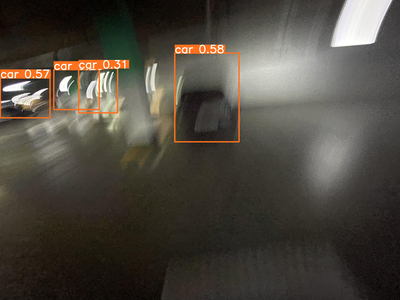

In [ ]:
img_name = 'img_2674' + '.jpg'
img = Image.open(os.path.join(f'/content/runs/detect/exp/', img_name))
img.thumbnail((400, 400), Image.ANTIALIAS)
img

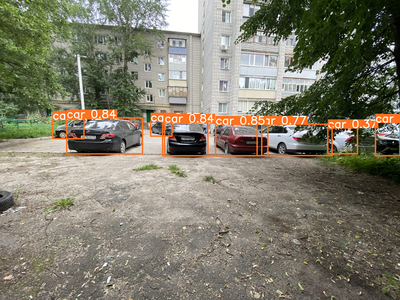

In [ ]:
img_name = 'img_1847' + '.jpg'
img = Image.open(os.path.join(f'/content/runs/detect/exp/', img_name))
img.thumbnail((400, 400), Image.ANTIALIAS)
img

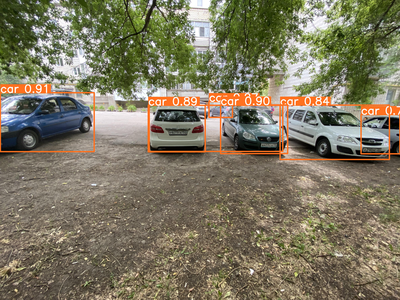

In [ ]:
img_name = 'img_2642' + '.jpg'
img = Image.open(os.path.join(f'/content/runs/detect/exp2/', img_name))
img.thumbnail((400, 400), Image.ANTIALIAS)
img

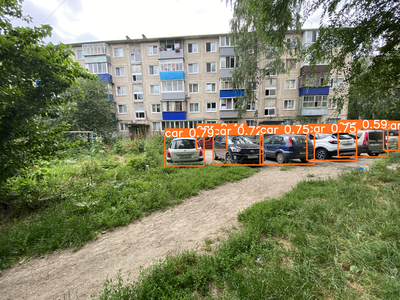

In [ ]:
img_name = 'img_1928' + '.jpg'
img = Image.open(os.path.join(f'/content/runs/detect/exp3/', img_name))
img.thumbnail((400, 400), Image.ANTIALIAS)
img

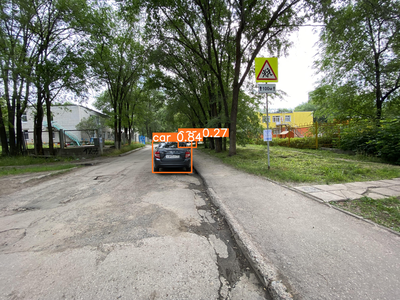

In [ ]:
img_name = 'img_2457' + '.jpg'
img = Image.open(os.path.join(f'/content/runs/detect/exp4/', img_name))
img.thumbnail((400, 400), Image.ANTIALIAS)
img

## **Конвертация heic в jpeg**

Опциональный и независимый раздел для проверки размеченных снимков. Снимки heic для показа разметки должны быть сначала сконвертированы в jpeg.

In [25]:
# Проверяем, что есть папки для хранения конвертированных файлов
train_conv = f'{CWD}train_converted/'
if not os.path.exists(train_conv):
    os.makedirs(train_conv)

test_conv = f'{CWD}test_converted/'
if not os.path.exists(test_conv):
    os.makedirs(test_conv)       

In [26]:
# Пишем функцию конвертации
register_heif_opener()

def convert_heic_to_jpeg(dir_in, dir_out):
        filenames = os.listdir(dir_in)
        filenames_matched = [re.search("\.HEIC$|\.heic$", filename) for filename in filenames]

         # Extract files of interest
        HEIC_files = []
        for index, filename in enumerate(filenames_matched):
                if filename:
                        HEIC_files.append(filenames[index])

        # Convert files to jpg while keeping the timestamp
        for filename in HEIC_files:
                image = Image.open(dir_in + "/" + filename)
                image_exif = image.getexif()
                if image_exif:
                        # Make a map with tag names and grab the datetime
                        exif = { ExifTags.TAGS[k]: v for k, v in image_exif.items() if k in ExifTags.TAGS and type(v) is not bytes }
                        date = datetime.strptime(exif['DateTime'], '%Y:%m:%d %H:%M:%S')

                        # Load exif data via piexif
                        exif_dict = piexif.load(image.info["exif"])

                        # Update exif data with orientation and datetime
                        exif_dict["0th"][piexif.ImageIFD.DateTime] = date.strftime("%Y:%m:%d %H:%M:%S")
                        exif_dict["0th"][piexif.ImageIFD.Orientation] = 1
                        exif_bytes = piexif.dump(exif_dict)

        # Convert files to jpg while keeping the timestamp
        for filename in tqdm (HEIC_files):
                image = Image.open(dir_in + "/" + filename)
                 # Save image as jpeg
                image.save(dir_out + "/" + os.path.splitext(filename)[0] + ".jpg", "jpeg", exif= exif_bytes)

In [27]:
#  Конвертируем тренировочные файлы .heic в .jpg и копируем их в отдельную директорию
convert_heic_to_jpeg (f'{CWD}train_dataset_train/train', 
                      f'{CWD}train_converted')

jpgCounter_ = len(glob.glob1(f'{CWD}train_converted',"*.jpg"))
print ("%d в формате .jpg" % (jpgCounter_))

100%|██████████| 48/48 [01:05<00:00,  1.36s/it]

48 в формате .jpg


In [15]:
#  Конвертируем тестовые файлы .heic в .jpg и копируем их в отдельную директорию
convert_heic_to_jpeg (f'{CWD}test', 
                      f'{CWD}test_converted')

jpgCounter_ = len(glob.glob1(f'{CWD}test_converted',"*.jpg"))
print ("%d в формате .jpg" % (jpgCounter_))

36 в формате .jpg
